In [1]:
import os
import numpy as np
import astropy.table as Table
import astropy.units as unit
import astropy.constants as cons
from astropy.io import fits
from astropy.table import Table
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.coordinates as coord
from astroquery.gaia import Gaia
import warnings
from pyia import GaiaData
from matplotlib.patches import Ellipse
#import mpld3
from astropy.coordinates import (ICRS, GalacticLSR, CartesianDifferential, CartesianRepresentation)
import stilism_extinction as stil
from scipy import optimize
from scipy.interpolate import UnivariateSpline
import datetime
import time
import ratelimiter as RL
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import UnivariateSpline
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io.votable import parse
# #Below settings for presentation figs
# import seaborn.apionly as sns
# sns.set_context('paper')
# plt.rcParams['savefig.dpi']=800
# plt.rcParams['ytick.labelsize']='large'
# plt.rcParams['xtick.labelsize']='large'
# plt.rcParams['axes.labelsize']=20
# plt.rcParams['figure.figsize']=(12.8,9.6)

#plt.style.use('HCH_plotstyle')
#%matplotlib inline
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
#from cycler import cycler
#plt.rcParams['axes.prop_cycle'] = cycler(color=['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7'])
# plt.rcParams["font.weight"] = "bold"
plt.rcParams['figure.figsize']=(2*3.35,2*.75*3.35)
#plt.rcParams['figure.dpi']=150
# plt.rcParams['font.size']=20
# plt.rcParams['font.family']='serif'
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']='True'
plt.rcParams['ytick.minor.visible']='True'

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
def fix_qatar_names(df):
    nonnull=df
    for i,sys in df.iterrows():
        if 'Qatar-' in sys.pl_hostname:
            df.loc[i, 'pl_hostname']='Qatar '+sys.pl_hostname[6:]
    return df

def load_dr25_usps(gaia_ids=True,  candidate_only=True, koi_score_cut=False):
    os.system('./DR25USPQuery.sh')
    dr25usps = pd.read_csv('DR25USPs.txt')
    dr25usps.rename(index=str,columns = {'ra':'ra_nasa','dec':'dec_nasa'}, inplace = True)
    dr25usps['KIC']=dr25usps['kepid'].astype(str)
    if koi_score_cut:
        dr25usps=dr25usps.loc[dr25usps.koi_score>0.68]
    if candidate_only:
        dr25usps=dr25usps.loc[((dr25usps.koi_disposition=='CANDIDATE')|(dr25usps.koi_disposition=='CONFIRMED'))]
    dr25usps=dr25usps.loc[dr25usps.koi_period<1]
    dr25usps['pl_orbper'] = dr25usps.koi_period
    dr25usps['pl_orbsmax'] = dr25usps.koi_sma
    dr25usps['pl_hostname'] = 'KIC '+dr25usps.KIC
    dr25usps=dr25usps[['pl_hostname','pl_orbper','pl_orbsmax','koi_score', 'koi_disposition']]
    dr25usps=fix_qatar_names(dr25usps)
    if gaia_ids:
        get_gaia_id_usps(dr25usps)
    return dr25usps

def load_confirmed_usps(gaia_ids=True):
    os.system('./ConfirmedUSPQuery.sh')
    confirmed_usps = pd.read_csv('confirmedUSPs.txt')
    confirmed_usps.rename(index=str,columns = {'ra':'ra_nasa','dec':'dec_nasa'}, inplace = True)
    confirmed_usps=confirmed_usps[['pl_hostname','pl_orbper','pl_orbsmax']]
    confirmed_usps=fix_qatar_names(confirmed_usps)
    confirmed_usps=confirmed_usps.loc[confirmed_usps.pl_orbper<1]
    if gaia_ids:
        get_gaia_id_usps(confirmed_usps)
    return confirmed_usps

def load_non_kep_usps(gaia_ids=True):
    os.system('./NonKeplerUSPQuery.sh')
    nonkep_usps = pd.read_csv('nonkeplerUSPs.txt')
    nonkep_usps.rename(index=str,columns = {'ra':'ra_nasa','dec':'dec_nasa'}, inplace = True)
    nonkep_usps=nonkep_usps[['pl_hostname','pl_orbper','pl_orbsmax']]
    nonkep_usps=nonkep_usps.loc[nonkep_usps.pl_orbper<1]
    nonkep_usps=fix_qatar_names(nonkep_usps)
    if gaia_ids:
        get_gaia_id_usps(nonkep_usps)
        nonkep_usps.loc[nonkep_usps.pl_hostname=='KELT-16','gaia_id']='Gaia DR2 1864885215233116032'
    return nonkep_usps

def load_so_usps(gaia_ids=True):
    sousps = Table.read('../Data/asu.fit')
    sousps = sousps.to_pandas()
    sousps['KIC'] = sousps.KIC.str.decode('utf-8')
    sousps['pl_orbper'] = sousps.Porb
    sousps['pl_orbsmax'] = sousps.a_R_*sousps.R_*cons.R_sun.to('au')
    sousps['pl_hostname'] = 'KIC '+sousps.KIC
    sousps=sousps[['pl_hostname','pl_orbper','pl_orbsmax']]
    sousps=fix_qatar_names(sousps)
    if gaia_ids:
        get_gaia_id_usps(sousps)
    return sousps

def load_k2_usps(gaia_ids=True):
    k2usps=pd.read_csv('K2USP_10806/planet_table_machine.txt'\
                   , na_values=' ',index_col=False,header=None, skiprows=1\
                   , names=['Candidate','Campaign','Period','Period_errup','Period_errdn','t_0',\
                            't_0_errup','t_0_errdn','Duration','Duration_errup','Duration_errdn',\
                            'Depth','Depth_errup','Depth_errdn','RpRs','RpRs_errup','RpRs_errdn',\
                            'Rp','Rp_errup','Rp_errdn','Rstar','Rstar_errup','Rstar_errdn','aRstar',\
                            'aRstar_errup','aRstar_errdn','IncFlux','IncFlux_errup','IncFlux_errdn']\
                   , dtype={'Candidate':str,'Campaign':str,'Period':np.float64,'Period_errup':np.float64,\
                            'Period_errdn':np.float64,'t_0':np.float64,'t_0_errup':np.float64,\
                            't_0_errdn':np.float64,'Duration':np.float64,'Duration_errup':np.float64,\
                            'Duration_errdn':np.float64,'Depth':np.float64,'Depth_errup':np.float64,\
                            'Depth_errdn':np.float64,'RpRs':np.float64,'RpRs_errup':np.float64,\
                            'RpRs_errdn':np.float64,'Rp':np.float64,'Rp_errup':np.float64,\
                            'Rp_errdn':np.float64,'Rstar':np.float64,'Rstar_errup':np.float64,\
                            'Rstar_errdn':np.float64,'aRstar':np.float64,'aRstar_errup':np.float64,\
                            'aRstar_errdn':np.float64,'IncFlux':np.float64,'IncFlux_errup':np.float64,\
                            'IncFlux_errdn':np.float64})
    k2usps=k2usps.loc[k2usps.Period+3*k2usps.Period_errup<1]
    k2usps['pl_orbper'] = k2usps.Period
    k2usps['pl_orbsmax'] = k2usps.aRstar*k2usps.Rstar*cons.R_sun.to('au')
    k2usps['pl_hostname'] = np.nan*np.ones(len(k2usps))
    for i, sys in k2usps.iterrows():
        k2usps.loc[i, 'pl_hostname'] = 'EPIC '+sys.Candidate[:-2]
    k2usps=k2usps[['pl_hostname','pl_orbper','pl_orbsmax']]
    k2usps=fix_qatar_names(k2usps)
    if gaia_ids:
        get_gaia_id_usps(k2usps)
    return k2usps

def get_gaia_id_usps(data):
    Simbad.add_votable_fields('ids')
    ids=[]
    #ratel=RL.RateLimiter(4, period=1)
    for j in range(0,(len(data)//100)+1):
        if j<(len(data)//100):
            #print(j)
            for i, sys in data.iloc[j*100:(j+1)*100].iterrows():
                #print(j,i)
                #with ratel:
                s=Simbad.query_object(sys.pl_hostname)
                if s is not None:
                    s=s.to_pandas()
                    s['IDS']=s['IDS'].str.decode('utf-8')
                    gaiaid=[idx for idx in s['IDS'][0].split('|') if 'Gaia DR2' in idx]
                    if len(gaiaid)>0:
                        ids.append(gaiaid[0])
                    else:
                        ids.append(np.nan)
                else:
                    ids.append(np.nan)
            time.sleep(20)
        else:
            for i, sys in data.iloc[j*100:j*100+len(data)%100].iterrows():
                #print(j,i)
                #with ratel:
                s=Simbad.query_object(sys.pl_hostname)
                if s is not None:
                    s=s.to_pandas()
                    s['IDS']=s['IDS'].str.decode('utf-8')
                    gaiaid=[idx for idx in s['IDS'][0].split('|') if 'Gaia DR2' in idx]
                    if len(gaiaid)>0:
                        ids.append(gaiaid[0])
                    else:
                        ids.append(np.nan)
                else:
                    ids.append(np.nan)
    data['gaia_id']=ids

def construct_best_id(data):
    """Adds field 'best_id' of HIP/TYC IDs to the array, querying objects in SIMBAD for all alternative IDs.
    Args: 
        data - array
    Notes: 
        Gaia DR1 only uses HIP/TYC IDS. This looks for those IDS. Gaia DR2 has multiple best_neighbor tables, but
        this only does these two for now.
        First attempts all names, including names like HIP ##### A, but then strips the trailing A or B.
    """
    data['best_id'] = np.ones(len(data))*np.nan
    for i, system in data.iterrows():
        simquery = Simbad.query_objectids(system.pl_hostname)
        if simquery is None:
            name = system.pl_hostname[:-2] + system.pl_hostname[-2:].replace(' A','').replace(' B','')
            simquery = Simbad.query_objectids(name, cache=False)
        if simquery is None:
            continue
        tycid = [objid for objid in simquery.to_pandas()['ID'].values.astype(str) if 'TYC' in objid]
        hipid = [objid for objid in simquery.to_pandas()['ID'].values.astype(str) if 'HIP' in objid]
        if len(hipid)>0:
            data.loc[i, 'best_id'] = hipid[0]
        elif len(tycid)>0:
            data.loc[i, 'best_id'] = tycid[0]
        else:
            continue
    warnings.resetwarnings()
    
    
def gaia_xmatch_usps(data, unique = True):
    """Crossmatches the hot Jupiter data with Gaia DR2, first matching objects with HIP/TYC IDs and then performing positional searches.
    
    If unique, returns one Gaia object per hot Jupiter host.
    """
    
    gaia_bool = ~data.gaia_id.isnull()
    gaia_preided = data.loc[gaia_bool]
    gaiaids = str(tuple(gaia_preided.gaia_id.values))
    query = "SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b FROM gaiadr2.gaia_source AS gaia WHERE gaia.designation IN " + gaiaids
    gaiajob = Gaia.launch_job(query)
    gaiaided = gaiajob.get_data()
    gaiaided = gaiaided.to_pandas()
    gaiaided['designation'] = gaiaided['designation'].str.decode('utf-8')
    gaia_prematched = pd.merge(data, gaiaided, how='left',left_on='gaia_id', right_on='designation')
    print('Have simbad DR2 ids:',len(gaia_prematched.loc[~gaia_prematched.designation.isnull()]))
    
    srcids = gaia_prematched.loc[~gaia_prematched.designation.isnull()].designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')
    gaia_prematched.loc[~gaia_prematched.designation.isnull(),'source_id'] = gaia_prematched.loc[~gaia_prematched.designation.isnull()].designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')
    print(len(gaia_prematched.loc[~gaia_prematched.source_id.isnull()]))
    source_ids = str(tuple(srcids.values))
    designations = str(tuple(gaia_prematched.loc[~gaia_prematched.designation.isnull()].designation.values))
    bjonesquery = 'SELECT gaia.designation, bjones.r_est as "distance", bjones.r_lo, bjones.r_hi FROM external.gaiadr2_geometric_distance as bjones INNER JOIN gaiadr2.gaia_source as gaia ON bjones.source_id = gaia.source_id WHERE gaia.designation IN '+designations
    job = Gaia.launch_job(bjonesquery)
    jobdata = job.get_data()
    uspbjones = jobdata.to_pandas()
    uspbjones['designation']=uspbjones['designation'].str.decode('utf-8')
    #uspbjones=pd.read_csv('../Data/HotJupBailerJones.csv')#,dtype={'source_id':'long'})
    print('bjones dists',len(uspbjones.loc[~uspbjones.distance.isnull()]))
    gaia_prematched = pd.merge(gaia_prematched, uspbjones, how='left', left_on='designation', right_on='designation')
    print('after bjones merge on designation',len(gaia_prematched.loc[~gaia_prematched.distance.isnull()]))
    return gaia_prematched

def prepare_dr25_usp_sample(nongiants = True, delta_M_G0_cut = 1, bailer_jones = True,preloaded = False, kinematics = True, plx_prec_cut=True, clean_astrometry=True):
    if preloaded:
        matchedusps = pd.read_csv('Data/gaia_dr25_usp_xmatch.csv')
    else:
        dr25=load_dr25_usps()
        nonkep=load_non_kep_usps()
        k2=load_k2_usps()
        usps=pd.concat([dr25,nonkep,k2])
        sources=[]
        for i in range(len(dr25)):
            sources.append('DR25')
        for i in range(len(nonkep)):
            sources.append('Nonkep')
        for i in range(len(k2)):
            sources.append('K2')
        usps['source']=sources
        matchedusps = gaia_xmatch_usps(usps,unique = True)
        add_petigura_rvs(matchedusps)
        matchedusps=gaia_epoch_prop(matchedusps)
        matchedusps=add_APOGEE_rvs(matchedusps)        
        matchedusps=add_LAMOST_rvs(matchedusps)
        combine_rvs(matchedusps)
        matchedusps.to_csv('Data/gaia_dr25_usp_xmatch.csv')
    if plx_prec_cut:
        matchedusps=matchedusps.loc[matchedusps.parallax_over_error>10]
    if bailer_jones==False:
        matchedusps['distance'] = 1000 / matchedusps['parallax']
    if clean_astrometry:
        matchedusps=astrometrically_clean_USPs(matchedusps)
    extinction_correct_Gaia(matchedusps)
    if nongiants:
        matchedusps = keep_nongiants(matchedusps, delta_M_G0_cut = delta_M_G0_cut)
    if kinematics:
        matchedusps.to_csv('Data/gaia_dr25_usp_xmatch.csv')
        gd = GaiaData('Data/gaia_dr25_usp_xmatch.csv')
        c = gd.skycoord
        gal = c.galacticlsr
        gal.set_representation_cls('cartesian')
        matchedusps['gal_U'] = gal.v_x
        matchedusps['gal_V'] = gal.v_y
        matchedusps['gal_W'] = gal.v_z
        matchedusps['gal_u'] = gal.x
        matchedusps['gal_v'] = gal.y
        matchedusps['gal_w'] = gal.z
        matchedusps=fix_kinematics(matchedusps)
        matchedusps.to_csv('Data/matched_dr25_usp_kinematics.csv')
    #sweetcat=pd.read_table('../Data/SWEET-Cat.txt',header=None, na_values='~')
    #sweetcat.rename(columns={0:"Name",1:"HD_number",2:"RA",3:"Dec",4:"Vmag",5:"e_Vmag",6:"plx",7:"e_plx",8:"plx_source",9:"Teff ",10:"e_Teff ",11:"logg",12:"e_logg",13:"LC_logg",14:"e_LC_logg",15:"Vt",16:"e_Vt",17:"[Fe/H]",18:"e_[Fe/H]",19:"Mass",20:"e_Mass",21:"Reference",22:"Homogeneity_flag",23:"Last_Update",24:"Comments"},inplace=True)
    #for col in sweetcat.columns:
    #    if (col=="Name" or col=='Reference' or col=='Last_Update' or col=='Comments' or col=='plx_source' or 'HD_number'):
    #        continue
    #    elif col=='Homogeneity_flag':
    #        sweetcat[col]=sweetcat[col].astype(int)
    #    else:
    #        sweetcat[col]=sweetcat[col].astype(float)
    #sweetcat=sweetcat.loc[sweetcat.Homogeneity_flag==1]
    #matchedusps=pd.merge(matchedusps,sweetcat, left_on='pl_hostname', right_on='Name',how='left')
    return matchedusps


def prepare_so_usp_sample(nongiants = True, delta_M_G0_cut = 1, bailer_jones = True,preloaded = False, kinematics = True, plx_prec_cut=True, clean_astrometry=True):
    if preloaded:
        matchedusps = pd.read_csv('Data/gaia_so_usp_xmatch.csv')
    else:
        so=load_so_usps()
        nonkep=load_non_kep_usps()
        k2=load_k2_usps()
        usps=pd.concat([so,nonkep,k2])
        sources=[]
        for i in range(len(so)):
            sources.append('SO')
        for i in range(len(nonkep)):
            sources.append('Nonkep')
        for i in range(len(k2)):
            sources.append('K2')
        usps['source']=sources
        matchedusps = gaia_xmatch_usps(usps,unique = True)
        add_petigura_rvs(matchedusps)
        matchedusps=gaia_epoch_prop(matchedusps)
        matchedusps=add_APOGEE_rvs(matchedusps)        
        matchedusps=add_LAMOST_rvs(matchedusps)
        combine_rvs(matchedusps)
        matchedusps.to_csv('Data/gaia_so_usp_xmatch.csv')
    if plx_prec_cut:
        matchedusps=matchedusps.loc[matchedusps.parallax_over_error>10]
    if bailer_jones==False:
        matchedusps['distance'] = 1000 / matchedusps['parallax']
    if clean_astrometry:
        matchedusps=astrometrically_clean_USPs(matchedusps)
    extinction_correct_Gaia(matchedusps)
    if nongiants:
        matchedusps = keep_nongiants(matchedusps, delta_M_G0_cut = delta_M_G0_cut)
    if kinematics:
        matchedusps.to_csv('Data/gaia_so_usp_xmatch.csv')
        gd = GaiaData('Data/gaia_so_usp_xmatch.csv')
        c = gd.skycoord
        gal = c.galacticlsr
        gal.set_representation_cls('cartesian')
        matchedusps['gal_U'] = gal.v_x
        matchedusps['gal_V'] = gal.v_y
        matchedusps['gal_W'] = gal.v_z
        matchedusps['gal_u'] = gal.x
        matchedusps['gal_v'] = gal.y
        matchedusps['gal_w'] = gal.z
        matchedusps=fix_kinematics(matchedusps)
        matchedusps.to_csv('Data/matched_so_usp_kinematics.csv')
    #sweetcat=pd.read_table('../Data/SWEET-Cat.txt',header=None, na_values='~')
    #sweetcat.rename(columns={0:"Name",1:"HD_number",2:"RA",3:"Dec",4:"Vmag",5:"e_Vmag",6:"plx",7:"e_plx",8:"plx_source",9:"Teff ",10:"e_Teff ",11:"logg",12:"e_logg",13:"LC_logg",14:"e_LC_logg",15:"Vt",16:"e_Vt",17:"[Fe/H]",18:"e_[Fe/H]",19:"Mass",20:"e_Mass",21:"Reference",22:"Homogeneity_flag",23:"Last_Update",24:"Comments"},inplace=True)
    #for col in sweetcat.columns:
    #    if (col=="Name" or col=='Reference' or col=='Last_Update' or col=='Comments' or col=='plx_source' or 'HD_number'):
    #        continue
    #    elif col=='Homogeneity_flag':
    #        sweetcat[col]=sweetcat[col].astype(int)
    #    else:
    #        sweetcat[col]=sweetcat[col].astype(float)
    #sweetcat=sweetcat.loc[sweetcat.Homogeneity_flag==1]
    #matchedusps=pd.merge(matchedusps,sweetcat, left_on='pl_hostname', right_on='Name',how='left')
    return matchedusps

def gaia_xmatch(data, unique = True):
    """Crossmatches the hot Jupiter data with Gaia DR2, first matching objects with HIP/TYC IDs and then performing positional searches.
    
    If unique, returns one Gaia object per hot Jupiter host.
    """
    
    gaia_bool = ~data.gaia_id.isnull()
    gaia_preided = data.loc[gaia_bool]
    gaiaids = str(tuple(gaia_preided.gaia_id.values))
    query = "SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b FROM gaiadr2.gaia_source AS gaia WHERE gaia.designation IN " + gaiaids
    gaiajob = Gaia.launch_job(query)
    gaiaided = gaiajob.get_data()
    gaiaided = gaiaided.to_pandas()
    gaiaided['designation'] = gaiaided['designation'].str.decode('utf-8')
    gaia_prematched = pd.merge(data, gaiaided, how='left',left_on='gaia_id', right_on='designation')
    print('Have simbad DR2 ids:',len(gaia_prematched.loc[~gaia_prematched.designation.isnull()]))
    
    construct_best_id(data)
    idable = data.gaia_id.isnull()
    idableusps = data.loc[idable]
    idableusps = idableusps.loc[~idableusps.best_id.isnull()]
    hipusps = idableusps.loc[~idableusps.hip_name.isnull()]
    tycusps = idableusps.loc[idableusps.hip_name.isnull()]
    hipids = str(tuple(hipusps.best_id.values)).replace('HIP ','').replace(' A','').replace(' B','')
    tycids = str(tuple(tycusps.best_id.values)).replace('TYC ','').replace(' A','').replace(' B','')
    if ((len(tycusps.best_id.values)>2)&(len(hipusps.best_id.values)>2)):
        #query = "SELECT gaia.designation, gaia.source_id, gaia.ra AS ra_gaia, gaia.ra_error AS ra_error_gaia, gaia.dec AS dec_gaia, gaia.dec_error AS dec_error_gaia, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_g_mean_mag, gaia.bp_rp, xmatch.original_ext_source_id FROM gaiadr2.gaia_source AS gaia INNER JOIN gaiadr2.hipparcos2_best_neighbour AS xmatch ON gaia.source_id = xmatch.source_id WHERE xmatch.original_ext_source_id IN " + hipids
        query = "SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b, xmatch.original_ext_source_id FROM gaiadr2.gaia_source AS gaia INNER JOIN gaiadr2.hipparcos2_best_neighbour AS xmatch ON gaia.source_id = xmatch.source_id WHERE xmatch.original_ext_source_id IN " + hipids
        hipjob = Gaia.launch_job(query)
        #query = "SELECT gaia.designation, gaia.source_id, gaia.ra AS ra_gaia, gaia.ra_error AS ra_error_gaia, gaia.dec AS dec_gaia, gaia.dec_error AS dec_error_gaia, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_g_mean_mag, gaia.bp_rp, xmatch.original_ext_source_id FROM gaiadr2.gaia_source AS gaia INNER JOIN gaiadr2.tycho2_best_neighbour AS xmatch ON gaia.source_id = xmatch.source_id WHERE xmatch.original_ext_source_id IN " + tycids
        query = "SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b, xmatch.original_ext_source_id FROM gaiadr2.gaia_source AS gaia INNER JOIN gaiadr2.tycho2_best_neighbour AS xmatch ON gaia.source_id = xmatch.source_id WHERE xmatch.original_ext_source_id IN " + tycids
        tycjob = Gaia.launch_job(query)
        hipgaia = hipjob.get_data()
        hipgaiapandas = hipgaia.to_pandas()
        hipgaiapandas['original_ext_source_id'] = hipgaiapandas['original_ext_source_id'].values.astype(int).astype(str)
        hipgaiapandas['original_ext_source_id'] = 'HIP ' + hipgaiapandas['original_ext_source_id']
        tycgaia = tycjob.get_data()
        tycgaiapandas = tycgaia.to_pandas()
        tycgaiapandas['original_ext_source_id'] = tycgaiapandas['original_ext_source_id'].astype(str)
        tycgaiapandas['original_ext_source_id'] = 'TYC ' + tycgaiapandas['original_ext_source_id']
        idablegaia = pd.concat([hipgaiapandas,tycgaiapandas])
        idablegaia['designation'] = idablegaia['designation'].str.decode('utf-8')
        idable_xmatch = pd.merge(data,idablegaia,how = 'left',left_on = 'best_id',right_on = 'original_ext_source_id')
        print('From best neighbor:',len(idable_xmatch.loc[~idable_xmatch.designation.isnull()]))
        print('Check the merges have same len',len(gaia_prematched),len(idable_xmatch))
    else:
        idable_xmatch = data
        idable_xmatch['designation']=np.ones(len(data))*np.nan
    
    nomatch1 = gaia_prematched.designation.isnull()
    nomatch2 = idable_xmatch.designation.isnull()
    in_neither = nomatch1 & nomatch2
    match1 = gaia_prematched.loc[~gaia_prematched.designation.isnull()]
    print('Check simbad set have designations', len(match1.loc[~match1.designation.isnull()]))
    match2 = idable_xmatch.loc[~idable_xmatch.designation.isnull()]
    print('Check best neighbor set have designations', len(match2.loc[~match2.designation.isnull()]))
    nogaiamatch = data.loc[in_neither]
    print(len(nogaiamatch))
    nogaiamatch = nogaiamatch.drop_duplicates(subset='pl_hostname')
    get_simbad_coordinates_pms_mags(nogaiamatch)

    frames = []
    for i, system in nogaiamatch.iterrows():
        if ~np.isnan(system.Simbad_RA):
            ra = system.Simbad_RA
        else:
            ra = system.ra_nasa
        if ~np.isnan(system.Simbad_DEC):
            dec = system.Simbad_DEC
        else:
            dec = system.dec_nasa
        print(ra,dec, system.pl_hostname)
        #query = "SELECT DISTANCE(EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, radial_velocity, 2015.5, 2000),POINT('ICRS'," + str(ra) + "," + str(dec) + ")) AS angular_distance_deg, gaia.designation, gaia.source_id, gaia.ra AS ra_gaia, gaia.ra_error AS ra_error_gaia, gaia.dec AS dec_gaia, gaia.dec_error AS dec_error_gaia, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_g_mean_mag, gaia.bp_rp FROM gaiadr2.gaia_source AS gaia WHERE 1 = CONTAINS(POINT('ICRS',ra, dec),CIRCLE('ICRS'," + str(ra) + "," + str(dec) + ",0.005555556))"
        query = "SELECT DISTANCE(EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, radial_velocity, ref_epoch, 2000),POINT('ICRS'," + str(ra) + "," + str(dec) + "))*3600. AS angular_distance_as, gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b FROM gaiadr2.gaia_source AS gaia WHERE 1 = CONTAINS(POINT('ICRS',ra, dec),CIRCLE('ICRS'," + str(ra) + "," + str(dec) + ",0.002777777777777778))"
        job = Gaia.launch_job(query)
        jobdata = job.get_data()
        jobdatapandas = jobdata.to_pandas()
        jobdatapandas['original_object'] = [system.pl_hostname for i in range(len(jobdata))]
        frames.append(jobdatapandas)
    positionalgaia = pd.concat(frames)
    positional_xmatch = pd.merge(nogaiamatch, positionalgaia, how = 'outer', left_on = 'pl_hostname', right_on = 'original_object')
    print('Found in positional',len(positional_xmatch))
    positional_xmatch = convert_gaia_photometry_xmatch(positional_xmatch)
    print('After cutting positional based on mags',len(positional_xmatch))
    fullxmatch = pd.concat([match1, match2, positional_xmatch])
    print('match1, match2, full should equal',len(match1.loc[~match1.designation.isnull()]),len(match2.loc[~match2.designation.isnull()]),len(fullxmatch.loc[~fullxmatch.designation.isnull()]))
    #ided = ~fullxmatch.designation_x.isnull()
    #positioned = ~fullxmatch.designation_y.isnull()    
    #for col in [col for col in fullxmatch.columns if '_x' in col]:
    #    col = col.replace('_x','')
    #    fullxmatch.loc[ided, col] = fullxmatch.loc[ided, col + '_x']
    #    fullxmatch.loc[positioned, col] = fullxmatch.loc[positioned, col + '_y']
    #    fullxmatch.drop(col + '_x', axis = 1, inplace = True)
    #    fullxmatch.drop(col + '_y', axis = 1, inplace = True)
    fullxmatch.drop_duplicates(subset = 'designation',keep = 'first',inplace = True)
    print('after drop duplicates',len(fullxmatch.loc[~fullxmatch.designation.isnull()]))
    fullxmatch.loc[fullxmatch.angular_distance_as.isnull(),'angular_distance_as'] = 0.
    print('after ang dist fix',len(fullxmatch.loc[~fullxmatch.designation.isnull()]))
    #fullxmatch['designation'] = fullxmatch['designation'].str.decode('utf-8')
    #print('after designation decode',len(fullxmatch.loc[~fullxmatch.designation.isnull()]))
    #if unique:
    #    fullxmatch = fullxmatch.loc[fullxmatch.designation != 'Gaia DR2 6780546169633474944']
    #    fullxmatch = fullxmatch.loc[fullxmatch.designation != 'Gaia DR2 2080056067370451456']
    #print('after unique',len(fullxmatch.loc[~fullxmatch.designation.isnull()]))
    srcids = fullxmatch.loc[~fullxmatch.designation.isnull()].designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')
    fullxmatch.loc[~fullxmatch.designation.isnull(),'source_id'] = fullxmatch.loc[~fullxmatch.designation.isnull()].designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')
    print(len(fullxmatch.loc[~fullxmatch.source_id.isnull()]))
    source_ids = str(tuple(srcids.values))
    designations = str(tuple(fullxmatch.loc[~fullxmatch.designation.isnull()].designation.values))
    bjonesquery = 'SELECT gaia.designation, bjones.r_est as "distance", bjones.r_lo, bjones.r_hi FROM external.gaiadr2_geometric_distance as bjones INNER JOIN gaiadr2.gaia_source as gaia ON bjones.source_id = gaia.source_id WHERE gaia.designation IN '+designations
    job = Gaia.launch_job(bjonesquery)
    jobdata = job.get_data()
    uspbjones = jobdata.to_pandas()
    uspbjones['designation']=uspbjones['designation'].str.decode('utf-8')
    #uspbjones=pd.read_csv('../Data/HotJupBailerJones.csv')#,dtype={'source_id':'long'})
    print('bjones dists',len(uspbjones.loc[~uspbjones.distance.isnull()]))
    fullxmatch = pd.merge(fullxmatch, uspbjones, how='left', left_on='designation', right_on='designation')
    print('after bjones merge on designation',len(fullxmatch.loc[~fullxmatch.distance.isnull()]))
    return fullxmatch

def add_petigura_rvs(df):
    df.pl_hostname=df.pl_hostname.str.strip(' ')
    df['petigura_radial_velocity']=np.ones(len(df))*np.nan
    petigura = pd.read_csv('../Data/petigura2017.csv')
    petigura['KIC'] = 'KIC '+petigura['KIC'].astype(str)
    inboth=[name for name in petigura['KIC'].values if name in df['pl_hostname'].values]
    keep1=np.ones(len(df),dtype=bool)
    keep2=np.ones(len(petigura),dtype=bool)
    for sys in inboth:
        df.loc[df.pl_hostname==sys,'petigura_radial_velocity']=petigura.loc[petigura.KIC==sys, 'TRV'].values
        keep1=(keep1&(df.pl_hostname!=sys))
        keep2=(keep2&(petigura.KIC!=sys))
    #     fig=plt.figure(figsize=(12,6))
    #     ax=fig.add_subplot(121)#,projection='mollweide')
    #     ax.scatter(petigura.loc[keep2, '_RA'], petigura.loc[keep2, '_DE'],s=25, facecolor=None)
    #     ax.scatter(df.loc[keep1].ra, df.loc[keep1].dec, s=5)
    #     ax.set_ylim(petigura.loc[keep2, '_DE'].min(), petigura.loc[keep2, '_DE'].max())
    #     ax.set_xlim(petigura.loc[keep2, '_RA'].min(), petigura.loc[keep2, '_RA'].max())
    #     ax=fig.add_subplot(122)#,projection='mollweide')
    #     ax.scatter(petigura.loc[~keep2, '_RA'], petigura.loc[~keep2, '_DE'],s=25, facecolor=None)
    #     ax.scatter(df.loc[~keep1].ra, df.loc[~keep1].dec, s=5)
    #     ax.set_ylim(petigura.loc[~keep2, '_DE'].min(), petigura.loc[~keep2, '_DE'].max())
    #     ax.set_xlim(petigura.loc[~keep2, '_RA'].min(), petigura.loc[~keep2, '_RA'].max())
    return df
       
def add_APOGEE_rvs(df):
#     df=gaia_epoch_prop(df) 
    df['APOGEE_radial_velocity']=np.ones(len(df))*np.nan
    df['APOGEE_radial_velocity_err']=np.ones(len(df))*np.nan
    df['APOGEE_ra']=np.ones(len(df))*np.nan
    df['APOGEE_dec']=np.ones(len(df))*np.nan
    catalog = SkyCoord(ra=apogee.RA, dec=apogee.DEC, unit=(unit.deg, unit.deg))  
    c = SkyCoord(ra=df.ra_prop*unit.degree, dec=df.dec_prop*unit.degree)  
    idx, d2d, d3d = c.match_to_catalog_sky(catalog) 
    max_sep = .1 * unit.arcsec 
    sep_constraint = d2d < max_sep 
    c_matches = c[sep_constraint] 
    catalog_matches = catalog[idx[sep_constraint]]
    df.loc[sep_constraint, 'APOGEE_radial_velocity']=apogee.iloc[idx[sep_constraint]]['VHELIO_AVG'].values
    df.loc[sep_constraint, 'APOGEE_radial_velocity_err']=apogee.iloc[idx[sep_constraint]]['VERR'].values
    df.loc[sep_constraint, 'APOGEE_ra']=apogee.iloc[idx[sep_constraint]]['RA'].values
    df.loc[sep_constraint, 'APOGEE_dec']=apogee.iloc[idx[sep_constraint]]['DEC'].values
    return df

def add_LAMOST_rvs(df):
    #df=gaia_epoch_prop(df) 
    df['LAMOST_radial_velocity']=np.ones(len(df))*np.nan
    df['LAMOST_ra']=np.ones(len(df))*np.nan
    df['LAMOST_dec']=np.ones(len(df))*np.nan
    catalog = SkyCoord(ra=LAMOST.ra_LAMOST, dec=LAMOST.dec_LAMOST, unit=(unit.deg, unit.deg))  
    c = SkyCoord(ra=df.ra_prop*unit.degree, dec=df.dec_prop*unit.degree)  
    idx, d2d, d3d = c.match_to_catalog_sky(catalog) 
    max_sep = 1.0 * unit.arcsec 
    sep_constraint = d2d < max_sep 
    c_matches = c[sep_constraint] 
    catalog_matches = catalog[idx[sep_constraint]] 
    df.loc[sep_constraint, 'LAMOST_radial_velocity']=LAMOST.iloc[idx[sep_constraint]]['rv'].values
    df.loc[sep_constraint, 'LAMOST_ra']=LAMOST.iloc[idx[sep_constraint]]['ra_LAMOST'].values
    df.loc[sep_constraint, 'LAMOST_dec']=LAMOST.iloc[idx[sep_constraint]]['dec_LAMOST'].values
    #     usps_LAMOST=pd.merge(left=df.loc[sep_constraint].reset_index(drop=True), right=LAMOST.loc[idx[sep_constraint]].reset_index(drop=True), how='left', left_index=True, right_index=True)
    #     inboth=[name for name in usps_LAMOST.designation.values if name in df['designation'].values]
    #     for sys in inboth:
    #         #print(sys, usps_LAMOST.loc[usps_LAMOST.designation==sys, ['mag1','magtype' ,'rv']])
    #         #print(sys, np.abs(df.loc[df.designation==sys,'phot_g_mean_mag'].values[0]-usps_LAMOST.loc[usps_LAMOST.designation==sys, 'mag1'].values[0]),'\n\n')
    #         #if np.abs(df.loc[df.designation==sys,'phot_g_mean_mag'].values[0]-usps_LAMOST.loc[usps_LAMOST.designation==sys, 'mag1'].values[0])<0.5:
    #         df.loc[df.designation==sys,'LAMOST_radial_velocity']=usps_LAMOST.loc[usps_LAMOST.designation==sys, 'rv'].values
    #         df.loc[df.designation==sys,'LAMOST_ra']=usps_LAMOST.loc[usps_LAMOST.designation==sys, 'ra_LAMOST'].values
    #         df.loc[df.designation==sys,'LAMOST_dec']=usps_LAMOST.loc[usps_LAMOST.designation==sys, 'dec_LAMOST'].values
    return df

def combine_rvs(df):
    df['gaia_rv']=df['radial_velocity']
    df['radial_velocity']=np.ones(len(df))*np.nan
    df['rv_source']=[' ' for i in range(len(df))]
    has_pet=~df.petigura_radial_velocity.isnull()
    has_gaia=~df.gaia_rv.isnull()
    has_LAMOST=~df.LAMOST_radial_velocity.isnull()
    has_APOGEE=~df.APOGEE_radial_velocity.isnull()
    df.loc[has_pet, 'radial_velocity']=df.loc[has_pet, 'petigura_radial_velocity']
    df.loc[has_pet, 'rv_source']='Petigura'
    no_pet_has_gaia=(has_gaia&(~has_pet))
    df.loc[no_pet_has_gaia, 'radial_velocity']=df.loc[no_pet_has_gaia, 'gaia_rv']
    df.loc[no_pet_has_gaia, 'rv_source']='Gaia'
    no_pet_no_gaia_has_APOGEE=(((~has_pet)&(~has_gaia))&has_APOGEE)
    df.loc[no_pet_no_gaia_has_APOGEE, 'radial_velocity']=df.loc[no_pet_no_gaia_has_APOGEE, 'APOGEE_radial_velocity']
    df.loc[no_pet_no_gaia_has_APOGEE, 'rv_source']='APOGEE'
    no_pet_no_gaia_no_apo_has_LAMOST=(((~has_pet)&(~has_gaia))&(~has_APOGEE))&has_LAMOST
    df.loc[no_pet_no_gaia_no_apo_has_LAMOST, 'radial_velocity']=df.loc[no_pet_no_gaia_no_apo_has_LAMOST, 'LAMOST_radial_velocity']
    df.loc[no_pet_no_gaia_no_apo_has_LAMOST, 'rv_source']='LAMOST'
    
def gaia_epoch_prop(df):
    designations_str = str(tuple(df.loc[~df.designation.isnull(), 'designation'].values.tolist()))
    query = "SELECT designation, COORD1(EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, radial_velocity, ref_epoch, 2000)), COORD2(EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, radial_velocity, ref_epoch, 2000)) FROM gaiadr2.gaia_source AS gaia WHERE designation IN "+designations_str
    job = Gaia.launch_job(query)
    jobdata = job.get_data()
    jobdatapandas = jobdata.to_pandas()
    jobdatapandas.designation = jobdatapandas.designation.str.decode('utf-8')
    jobdatapandas['ra_prop']=jobdatapandas['coord1']
    jobdatapandas['dec_prop']=jobdatapandas['coord2']
    jobdatapandas=jobdatapandas[['designation','ra_prop','dec_prop']]
    matched=pd.merge(df, jobdatapandas, left_on='designation', right_on='designation')
    return matched

def fix_kinematics(df):
    norv=df.radial_velocity.isnull()
    nopmra=df.pmra.isnull()
    nopmdec=df.pmdec.isnull()
    noplx=df.parallax.isnull()
    missing_any= norv|nopmra|nopmdec|noplx
    df.loc[missing_any,'gal_U']=np.nan
    df.loc[missing_any,'gal_V']=np.nan
    df.loc[missing_any,'gal_W']=np.nan
    return df

def convert_gaia_photometry_xmatch(data):
    """Converts the Gaia photometry to Johnson system to allow for verification of crossmatch by apparent magnitude.
    
    See https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html
    """
    data['gaia_V'] = data['phot_g_mean_mag'] + 0.1732*data['bp_rp']**2 + 0.006860*data['bp_rp'] + 0.01760
    data = data.loc[np.abs(data['gaia_V']-data['Simbad_FLUX_V'])<1]
    return data

def abs_G_mag(data):
    data['distance_pc'] = 1000./data['parallax']
    data['G_mag_abs'] = data['phot_g_mean_mag'] + 5-5*np.log10(data['distance_pc'])
    

def compute_delta_M_G0(data):
    """Calulate deviation from main-sequence M_G - bp_rp color polynomial relation derived from the Pleiades Gaia DR2 data. 
    Used to remove giants.
    
    Args:
        data - array of data with extinction and reddening corrected Gaia photometry.
    """
    tcks=([-0.1533484 , -0.1533484 , -0.1533484 , -0.1533484 ,  0.63099294,
         0.96258741,  1.30771737,  1.71082406,  2.1444674 ,  2.4671927 ,
         2.5106812 ,  2.57087331,  2.61055761,  2.64182287,  2.65866666,
         2.66738897,  2.69233232,  2.70922952,  2.77087217,  2.82155137,
         2.84336095,  2.8537417 ,  2.89164453,  2.919838  ,  2.95142656,
         2.96471505,  2.98843198,  3.01530652,  3.04317003,  3.05686288,
         3.07316022,  3.10154062,  3.12891012,  3.16318994,  3.21736532,
         3.27362256,  3.3727818 ,  3.68525129,  3.68525129,  3.68525129,
         3.68525129],[-0.1745295 ,  2.3230733 ,  2.54252414,  5.54631992,  6.59988118,
         7.76297267,  8.59023705,  9.17519988,  9.65855025,  9.77533754,
         9.90392849, 10.05051825, 10.13809934, 10.19273253, 10.21350097,
        10.24293815, 10.38722777, 10.6498557 , 10.67855244, 10.68741252,
        10.71899853, 10.92565851, 10.97186376, 11.00763527, 11.08921082,
        11.27865818, 11.34078682, 11.34813415, 11.35886986, 11.42840745,
        11.55213609, 11.6855607 , 11.71061756, 12.12229352, 12.26016258,
        12.22448534, 12.8920296 ,  0.        ,  0.        ,  0.        ,
         0.        ],3)
    spl2=UnivariateSpline._from_tck(tcks)
    #a=np.array([ -0.0491425 ,   0.81243621,  -5.52471938,  19.74213029,-39.20921495,  42.06379052, -22.26781161,   8.91746038, 0.7786397 ])
    data['delta_M_G0'] = np.ones(len(data))*np.nan
    spline_val=spl2(data.bp_rp0)
    #poly = np.polyval(a,data.bp_rp0)
    #data['delta_M_G0'] = poly+5-5*np.log10(135.81630262048824)-data['M_G0'] #Average distance to Pleiades
    #data['delta_M_G0']=poly-data['M_G0']  # as poly is currently already in abs mag
    data['delta_M_G0']=spline_val-data['M_G0']  # as poly is currently already in abs mag
    return data


def plot_pleiades_main_sequence_poly(ax, minbprp = 0.2, maxbprp = 2.0):
    """Plot the main sequence polynomial derived from the Pleiades."""
    a=np.array([ -0.0491425 ,   0.81243621,  -5.52471938,  19.74213029,-39.20921495,  42.06379052, -22.26781161,   8.91746038, 0.7786397 ])
    bprps = np.linspace(minbprp, maxbprp, 100)
    polys = np.polyval(a,bprps)
    ax.plot(bprps, polys, zorder = 10, lw=2, c='k',ls='-.',alpha=0.75, label='Pleiades Main Sequence')
    return

def keep_nongiants(data, delta_M_V_cut = 1., delta_M_G0_cut=1., gaia=True):
    if gaia:       
        data = compute_delta_M_G0(data)
        nongiants = (data.loc[data.delta_M_G0<delta_M_G0_cut])
    else:
        data = compute_delta_M_V(data)
        nongiants = (data.loc[data.delta_M_V<delta_M_V_cut])
    return nongiants

def giants_nongiants_HR(data, delta_M_V_cut = 1, delta_M_G0_cut=1, gaia=True):
    f,ax=plt.subplots(1)
    if gaia:
        data = compute_delta_M_G0(data)
        nongiants = (data.loc[data.delta_M_G0<delta_M_G0_cut])
        giants = (data.loc[data.delta_M_G0>delta_M_G0_cut])
        plot_pleiades_main_sequence_poly(ax)
        if len(data)>1000:
            ax.scatter(nongiants.bp_rp0, nongiants.M_G0, color = 'b',s=5,alpha=0.02)
            ax.scatter(giants.bp_rp0, giants.M_G0, color = 'r',s=5,alpha=0.02)
        else:
            ax.scatter(nongiants.bp_rp0, nongiants.M_G0, color = 'b',s=10,alpha=0.6)
            ax.scatter(giants.bp_rp0, giants.M_G0, color = 'r',s=10,alpha=0.6)    
        ax.set_xlabel('$(G_{BP}-G_{RP})_0$')
        ax.set_ylabel('$M_{G0}$')
    else:
        data = compute_delta_M_V(data)
        nongiants = (data.loc[data.delta_M_V<delta_M_V_cut])
        giants = (data.loc[data.delta_M_V>delta_M_V_cut])
        #plot_main_sequence_poly(.44, 1.2)
        if len(data)>1000:
            ax.scatter(nongiants.B_V0, nongiants.V0, color = 'b',s=5,alpha=0.02)
            ax.scatter(giants.B_V0, giants.V0, color = 'r',s=5,alpha=0.02)
        else:
            ax.scatter(nongiants.B_V0, nongiants.V0, color = 'b',s=10,alpha=0.6)
            ax.scatter(giants.B_V0, giants.V0, color = 'r',s=10,alpha=0.6)
        ax.set_xlabel('$(B-V)_0$')
        ax.set_ylabel('$M_V0$')
    ax.invert_yaxis()
    return f,ax
                 
                 
def sp_type_vel_scatter(ax, usps, control, bprpbounds, comp1, comp2, both_ellipse=True):
    if both_ellipse:
        ax.grid(alpha = 0.15) 
        uspbprp = usps.bp_rp0
        hotjup_sptype = usps.loc[np.logical_and(uspbprp>bprpbounds[0],uspbprp<bprpbounds[1])]
        xusp = hotjup_sptype['gal_' + comp1].dropna().values
        yusp = hotjup_sptype['gal_' + comp2].dropna().values
        xstdusp = xusp.std()
        ystdusp = yusp.std()
        ellsusp = [Ellipse((xusp.mean(),yusp.mean()), (1 + i)*xstdusp, (1 + i)*ystdusp) for i in range(3)]
        for i, e in enumerate(ellsusp):
            e.set_clip_box(ax.bbox)
            e.set_alpha(0.75/(i+1))
            e.set_fill(False)
            e.set_ec('b')
            e.set_linewidth(4)
            ax.add_artist(e)

        controlbprp = control.bp_rp0
        control_sptype = control.loc[np.logical_and(controlbprp>bprpbounds[0], controlbprp<bprpbounds[1])]
        xcontrol = control_sptype['gal_' + comp1].dropna().values
        ycontrol = control_sptype['gal_' + comp2].dropna().values
        xstdcontrol = xcontrol.std()
        ystdcontrol = ycontrol.std()
        ellscontrol = [Ellipse((xcontrol.mean(),ycontrol.mean()), (1 + i)*xstdcontrol, (1 + i)*ystdcontrol) for i in range(3)]
        for e in ellscontrol:
            e.set_clip_box(ax.bbox)
            e.set_alpha(0.15)
            e.set_facecolor('k')
            ax.add_artist(e)
    else:
        ax.grid(alpha = 0.15)
        uspbprp = usps.bp_rp0
        hotjup_sptype = usps.loc[np.logical_and(uspbprp>bprpbounds[0],uspbprp<bprpbounds[1])]
        controlbprp = control.bp_rp0
        control_sptype = control.loc[np.logical_and(controlbprp>bprpbounds[0], controlbprp<bprpbounds[1])]
        x = control_sptype['gal_' + comp1].dropna().values
        y = control_sptype['gal_' + comp2].dropna().values
        xstd = x.std()
        ystd = y.std()
        ells = [Ellipse((x.mean(),y.mean()), (1 + i)*xstd, (1 + i)*ystd) for i in range(3)]
        for e in ells:
            e.set_clip_box(ax.bbox)
            e.set_alpha(0.15)
            e.set_facecolor('k')
            ax.add_artist(e)
        ax.scatter(hotjup_sptype['gal_' + comp1], hotjup_sptype['gal_' + comp2], s = 10)
    ax.set_ylabel('${}$ [km/s]'.format(comp2), labelpad = -15, fontsize = 24)
    ax.set_yticks([-50,-25,0,25,50])
    ax.set_xticks([-50,-25,0,25,50])
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')
    ax.annotate(s='N={}'.format(len(hotjup_sptype)), xy=(.70,.84),xycoords='axes fraction', fontsize=26)
        
def all_sp_vel_scatter(usps, control, both_ellipse=True):
    f, ax = plt.subplots(3,3, figsize = (21,21),sharex=True)
    bounds = ((.438,.742),(.742,1.002),(1.002,2.02))
    sptypes = ('F', 'G', 'K')
    for i, bound in enumerate(bounds):
        sp_type_vel_scatter(ax[i][0], usps, control, bound, 'U', 'V', both_ellipse)
        sp_type_vel_scatter(ax[i][1], usps, control, bound, 'U', 'W', both_ellipse)
        sp_type_vel_scatter(ax[i][2], usps, control, bound, 'V', 'W', both_ellipse)
        for j in range(3):
            if i==2:
                ax[i][j].set_xlabel('${}$ [km/s]'.format('UUV'[j]), labelpad = 0, fontsize = 24)
            ax[i][j].annotate(s = '{} Stars'.format(sptypes[i]), xy = (.13,.84), xycoords = 'axes fraction', fontsize = 26)
            ax[i][j].set_ylim(-65,65)
            ax[i][j].set_xlim(-65,65)
    f.tight_layout()
    f.subplots_adjust(hspace=0.01,wspace=.20)
    return f, ax


def total_deviation(data):
    total_deviation = np.sum(np.sqrt((data.gal_U-data.gal_U.mean())**2 + \
                                 (data.gal_V-data.gal_V.mean())**2 + \
                                 (data.gal_W-data.gal_W.mean())**2))
    return total_deviation

def match_zdistribution(usps, control):
    usp_z=usps['gal_w']
    control_z=control['gal_w']
    control=control.loc[(control_z>usp_z.min())&(control_z<usp_z.max())]
    control_z=control_z.loc[(control_z>usp_z.min())&(control_z<usp_z.max())]
    usphist,uspedges=np.histogram(usp_z,bins=12,density=True)
    ghist,gedges=np.histogram(control_z,bins=12,density=True)
    maxdisc=np.argmax(usphist/ghist)
    ideal_total=int(len(control.loc[(control.gal_w>uspedges[maxdisc])&(control.gal_w<uspedges[maxdisc+1])])/(usphist[maxdisc]/usphist.sum()))
    indices=[]
    for i,frac in enumerate(usphist/usphist.sum()):
        try:
            bin_indices=control.loc[(control.gal_w>uspedges[i])&(control.gal_w<uspedges[i+1])].sample(int(ideal_total*frac)).index.values
        except ValueError:
            bin_indices=control.loc[(control.gal_w>uspedges[i])&(control.gal_w<uspedges[i+1])].index.values
        indices.append(bin_indices)
    indices=np.concatenate(indices)
    return control.loc[indices]


def mc_control_deviations(usps, control, niters = 1000, metallicity=False, z_distribution=True, delta_M_G0_cut=1.):
    mciters = niters
    uspnongiants = keep_nongiants(usps,delta_M_G0_cut=delta_M_G0_cut)
    nongiants = keep_nongiants(control,delta_M_G0_cut=delta_M_G0_cut)
    total_deviations = np.ones(mciters)*np.nan
    samps = []
    for i in range(mciters):
        if metallicity:
            control_sample=match_metallicity(uspnongiants, nongiants)
        if z_distribution:
            control_sample=match_zdistribution(uspnongiants, nongiants)
        else: 
            control_sample=nongiants
        bprpcontrol = control_sample.bp_rp0
        if i%(mciters/10) == 0:
            print('i = ',i, datetime.datetime.now())
        control_sample_inds = []
        for j, usp in uspnongiants.iterrows():
            bprprange = 0.025
            bprp = usp.bp_rp0
            bounds = (bprp-bprprange,bprp + bprprange)
            selection=control_sample.loc[np.logical_and(bprpcontrol>bounds[0], bprpcontrol<bounds[1])]
            while len(selection)==0:
                bprprange+=.005
                bounds = (bprp-bprprange,bprp + bprprange)
                selection = control_sample.loc[np.logical_and(bprpcontrol>bounds[0], bprpcontrol<bounds[1])]
            control_sample_inds.append(selection.sample(n=1).index.values)
        control_sample_inds = np.concatenate(control_sample_inds)
        control_sample = nongiants.loc[control_sample_inds]
        total_deviationi = total_deviation(control_sample)
        total_deviations[i] = total_deviationi/len(control_sample[~control_sample.gal_U.isnull()])
        samps.append(control_sample)
    #(uspnongiants.Bmag-uspnongiants.Vmag).hist()
    #(control_sample.Bmag-control_sample.Vmag).hist()
    plt.scatter(uspnongiants.bp_rp0, uspnongiants.M_G0, label = 'Gaia usps')
    plt.scatter(control_sample.bp_rp0, control_sample.M_G0, label = 'Final Control Sample')
    plt.gca().invert_yaxis()
    return total_deviations, samps

def usp_vs_control_dispersion_hist(usps, control, mciters = 15000, metallicity=False, z_distribution=True, delta_M_G0_cut=1.):
    uspdevs = total_deviation(usps)/len(usps[~usps.gal_U.isnull()])
    control_devs, samps = mc_control_deviations(usps = usps, control = control, niters = mciters, metallicity=metallicity, z_distribution=z_distribution, delta_M_G0_cut=delta_M_G0_cut)
    #fig = plt.figure()
    #plt.hist(control_devs, bins = 100)
    #maxy = plt.gca().get_ylim()[1]
    #plt.vlines(uspdevs, ymin = 0, ymax = maxy, label = 'usp Total Dev', color = 'orange')
    #plt.vlines(x = np.percentile(control_devs,50), ymin = 0, ymax = maxy, label = 'Control Median', color = 'k')
    #plt.vlines(x = np.percentile(control_devs,[16,84]), ymin = 0, ymax = maxy, label = '1 $\\sigma$', color = 'k', linestyle = '--')
    #plt.vlines(x = np.percentile(control_devs,[2,98]), ymin = 0, ymax = maxy, label = '2 $\\sigma$', color = 'k', linestyle = '--',alpha=0.5)
    #plt.xlabel('Velocity Dispersion')
    #plt.legend()
    #plt.title('{} Iterations'.format(mciters))
    #plt.ylabel('Number of Monte Carlo Samples')
    #plt.annotate(s = "$usps:{:.3f}\%$".format(len(control_devs[control_devs<uspdevs])*100/len(control_devs)), xy = (0.1,.5), xycoords = 'axes fraction', fontsize = 14)
    return uspdevs, control_devs, samps
def extinction_correct_Johnson(data):
    data['ext_B_V'] = np.ones(len(data))*np.nan
    for i, sys in data.iterrows():
        data.loc[i, 'ext_B_V'] = stil.ext_calc(sys.l, sys.b, sys.distance, 100) 
    data['ext_V'] = 3.1*data['ext_B_V']
    data['V_mag_abs']=data['Vmag']+5-5*np.log10(data['distance'])
    data['V0'] = data['V_mag_abs']-data['ext_V']
    data['B_V0'] = data['B_V']-data['ext_B_V']
    
def extinction_correct_Gaia(data):
    data['ext_B_V'] = np.ones(len(data))*np.nan
    for i, sys in data.iterrows():
        data.loc[i, 'ext_B_V'] = stil.ext_calc(sys.l, sys.b, sys.distance, 100) 
    data['ext_bp_rp'] = (3.374-2.035)*data['ext_B_V'] # Casagrande & VandenBerg 2018 Table 2 
    data['ext_G'] = 2.740*data['ext_B_V'] # Casagrande & VandenBerg 2018 Table 2 
    data['bp_rp0'] = data['bp_rp']-data['ext_bp_rp']
    data['G0'] = data['phot_g_mean_mag']-data['ext_G']
    data['M_G0'] = data['phot_g_mean_mag']+5-5*np.log10(data['distance'])


def astrometrically_clean_USPs(usps):
    cut1 = usps.parallax_over_error>10
    cut2 = usps.astrometric_gof_al<3
    cut3 = np.logical_and(usps.mean_varpi_factor_al>-0.23,usps.mean_varpi_factor_al<0.36)
    cut4 = usps.visibility_periods_used>8
    #NEXT ONLY WORKS BECAUSE EXP(G-19.5) > 1 FOR ALL HOT JUP HOSTS, not best implementation
    cut5 = np.sqrt(usps.astrometric_chi2_al/(usps.astrometric_n_good_obs_al-5)) < 1.2*np.exp(-0.2*(usps.phot_g_mean_mag-19.5))
    #allcuts = (((cut1 & cut2) & cut3) & cut4) & cut5
    allcuts = ((cut1 & cut3) & cut4) & cut5
    print('Before cleaning: ',len(usps))
    print('Limiting to parallax_over_error>10: ',len(usps.loc[cut1]))
    print('Limiting to astrometric_gof_al<3: ',len(usps.loc[cut2]))
    print('Limiting to -0.23<mean_varpi_factor_al<0.36: ',len(usps.loc[cut3]))
    print('Limiting to visibility_periods_used>8: ',len(usps.loc[cut4]))
    print('Limiting to Lindegren cut C.1: ',len(usps.loc[cut5]))
    usps=usps.loc[allcuts]
    print('All cuts except gof_al:', len(usps))
    return usps


def prepare_astrometrically_clean_gaia(preloaded=False,nongiants = True, delta_M_G0_cut = 1, fgk_only = False, bailer_jones = True, kinematics = True, metallicities=False):
    if preloaded:
        gaia=pd.read_csv('../Data/GAIADR2_Clean_Astrometry_extincted.csv')
    else:
        gaia=pd.read_csv('../Data/Gaia_rough_main_sequence.csv',dtype={'source_id':'long'})
        gaia['source_id'] = gaia.designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')
        if bailer_jones==False:
            gaia['distance'] = 1000/gaia['parallax']

        extinction_correct_Gaia(gaia)
        
        #gaia['BTmag'] = gaia['G0'] + 0.02441 + 0.4899 * gaia['bp_rp0'] + 0.9740 * gaia['bp_rp0']**2 + 0.2496 * gaia['bp_rp0']**3
        #gaia['VTmag'] = gaia['G0'] + 0.01842 + 0.06629 * gaia['bp_rp0'] + 0.2346 * gaia['bp_rp0']**2 + 0.02157 * gaia['bp_rp0']**3
        #gaia['Vmag'] = gaia['VTmag']-0.09*(gaia['BTmag']-gaia['VTmag'])
        #gaia['B_V0'] = 0.85*(gaia['BTmag']-gaia['VTmag'])

        #gaia['V0'] = gaia['Vmag']+5-5*np.log10(gaia['distance'])
        
        #gaia['BTmag'] = gaia['phot_g_mean_mag'] + 0.02441 + 0.4899 * gaia['bp_rp'] + 0.9740 * gaia['bp_rp']**2 + 0.2496 * gaia['bp_rp']**3
        #gaia['VTmag'] = gaia['phot_g_mean_mag'] + 0.01842 + 0.06629 * gaia['bp_rp'] + 0.2346 * gaia['bp_rp']**2 + 0.02157 * gaia['bp_rp']**3
        #gaia['Vmag'] = gaia['VTmag']-0.09*(gaia['BTmag']-gaia['VTmag'])
        #gaia['B_V'] = 0.85*(gaia['BTmag']-gaia['VTmag'])

        #gaia['V0'] = gaia['Vmag']+5-5*np.log10(gaia['distance'])
        #extinction_correct_Johnson(gaia)
        gaia.to_csv('../Data/GAIADR2_Clean_Astrometry_extincted.csv')
    if fgk_only:
        print('Before FGK cut: ',len(gaia))
        gaia = gaia.loc[np.logical_and(gaia.B_V0>0.44,gaia.B_V0<1.2)]
        print('After FGK cut: ',len(gaia))
    if nongiants:
        print('Before MS cut: ',len(gaia))
        gaia = keep_nongiants(gaia, delta_M_G0_cut = delta_M_G0_cut,gaia=True)
        print('After MS cut: ', len(gaia))
    if kinematics:
        gaia.to_csv('../Data/gaia_nongiants.csv')
        gd = GaiaData('../Data/gaia_nongiants.csv')
        c = gd.skycoord
        gal = c.galacticlsr
        gal.set_representation_cls('cartesian')
        gaia['gal_U'] = gal.v_x
        gaia['gal_V'] = gal.v_y
        gaia['gal_W'] = gal.v_z
        gaia['gal_u'] = gal.x
        gaia['gal_v'] = gal.y
        gaia['gal_w'] = gal.z
        gaia.to_csv('../Data/gaia_nongiants_kinematics.csv')
    return gaia


In [3]:
apogee_hdul=fits.open('../Data/apogeedr12_allStar-v603.fits')
print(apogee_hdul[1].header)
cols=['J','H','K','APOGEE_ID','RA','DEC','SNR','STARFLAG','VHELIO_AVG','VERR']
apogee=pd.DataFrame()
for col in cols:
    apogee[col]=apogee_hdul[1].data[col].tolist()
apogee=apogee.loc[apogee.APOGEE_ID!='VESTA             ']

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           BITPIX  =                    8 /Required value                                  NAXIS   =                    2 /Required value                                  NAXIS1  =                 3868 /Number of bytes per row                         NAXIS2  =               163278 /Number of rows                                  PCOUNT  =                    0 /Normally 0 (no varying arrays)                  GCOUNT  =                    1 /Required value                                  TFIELDS =                  151 /Number of columns in table                      COMMENT                                                                         COMMENT  *** End of mandatory fields ***                                        COMMENT                                                                         COMMENT                                                                         COMMENT  *** Column names ***           

In [4]:
LAMOST=pd.read_csv('../Data/dr5_stellar.csv', sep='|')
tc_not_null=~LAMOST.tcomment.isnull()
LAMOST.loc[~tc_not_null, 'tcomment']='.'
kplr_in_tc=['kplr' in tc for tc in LAMOST['tcomment'].values]
LAMOST['KIC']=['' for i in range(len(LAMOST))]
LAMOST.loc[kplr_in_tc, 'KIC']='KIC '+LAMOST.loc[kplr_in_tc,'tcomment'].str.strip('kplr').str.lstrip('0')
LAMOST=LAMOST[['KIC','ra','dec','teff','teff_err','logg','logg_err','rv','rv_err', 'z', 'z_err', 'teff', 'mag1','mag2','mag3','mag4','mag5','magtype']]
LAMOST['ra_LAMOST']=LAMOST['ra']
LAMOST['dec_LAMOST']=LAMOST['dec']
LAMOST=LAMOST.drop('ra', axis=1)
LAMOST=LAMOST.drop('dec', axis=1)

/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
kepids=pd.read_csv('../Data/jacob/KTC_kep_ids.csv', header=None)
kepids['KIC']='KIC '+kepids[0].astype(str)
kepids.drop(0, axis=1, inplace=True)
kepids

In [5]:
not_in_db=open('../Data/jacob/not_in_db.txt','w+')
in_db=open('../Data/jacob/in_db.txt','w+')
fi=open('../Data/jacob/simbad_query_result_unedited.txt', 'r')
error=False
result=False
for i, line in enumerate(fi):
    if '::error::' in line:
        print(i)
        error|=True
    if '::data::' in line:
        print(i)
        result|=True
        error=False
    if error:
        not_in_db.write(line)
    if result:
        in_db.write(line)
fi.close()
not_in_db.close()
in_db.close()
not_in=pd.read_csv('../Data/jacob/not_in_db.txt', delimiter=':', skiprows=1, header=None)
not_in['KIC']=not_in[1]
not_in['indices']=not_in[0]
not_in.drop([0,1], axis=1, inplace=True)
not_in['indices']=not_in.indices.str.strip('] Identifier not found in the database').str.strip('[')
in_db=pd.read_csv('../Data/jacob/in_db.txt', delimiter=',',names=['KIC','designation'], skiprows=1, header=None)
in_db.loc[(~(in_db.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~in_db.designation.isnull()), 'KIC']=in_db.loc[(~(in_db.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~in_db.designation.isnull()), 'designation']
in_db.loc[(~(in_db.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~in_db.designation.isnull()), 'designation']=np.nan
in_db['designation']=in_db.designation.str.strip(' ')
ktc_no_gaia=pd.concat([in_db.loc[in_db.designation.isnull(), 'KIC'], not_in['KIC']])
ktc_no_gaia=ktc_no_gaia.str.strip('KIC ').astype(int)
ktc_no_gaia.to_csv('kic_ids.csv', index=False)
kic=pd.read_csv('../Data/jacob/KIC_ra_dec.tsv',skiprows=39, delimiter='\t', names=['KIC','RAJ2000','DECJ2000','Kep_mag'], header=None)
ktc_no_gaia_positions=pd.merge(left=ktc_no_gaia, right=kic, on='KIC', how='inner')
gaia_kep_epoch_prop_vot=parse("../Data/jacob/Kepler_Field_Epoch_Prop-result.vot")
gaia_kep_epoch_prop_tbl=gaia_kep_epoch_prop_vot.get_first_table()
gaia_kep_epoch_prop_tbl.fields
gaia_kep_epoch_prop=pd.DataFrame()
for col in ['source_id', 'designation', 'ra','dec','ra_2000','dec_2000']:
    gaia_kep_epoch_prop[col]=gaia_kep_epoch_prop_tbl.array[col].data
gaia_kep_epoch_prop.designation=gaia_kep_epoch_prop.designation.str.decode('utf-8')
def Kepler_Gaia_positional_xmatch(df):
    df['designation_positional']=np.ones(len(df))*np.nan
    catalog = SkyCoord(ra=gaia_kep_epoch_prop.ra_2000, dec=gaia_kep_epoch_prop.dec_2000, unit=(unit.deg, unit.deg))  
    c = SkyCoord(ra=df.RAJ2000*unit.degree, dec=df.DECJ2000*unit.degree)  
    idx, d2d, d3d = c.match_to_catalog_sky(catalog) 
    max_sep = 1.0 * unit.arcsec 
    sep_constraint = d2d < max_sep 
    c_matches = c[sep_constraint] 
    catalog_matches = catalog[idx[sep_constraint]] 
    df.loc[sep_constraint, 'designation_positional']=gaia_kep_epoch_prop.iloc[idx[sep_constraint]]['designation'].values
    return df
ktc_no_gaia_positions_matched=Kepler_Gaia_positional_xmatch(ktc_no_gaia_positions)
ktc_no_gaia_positions_matched.loc[~ktc_no_gaia_positions_matched.designation_positional.isnull()]

30
38472


/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


,KIC,RAJ2000,DECJ2000,Kep_mag,designation_positional
1634,8197356,300.93137,44.097450,14.364,Gaia DR2 2075877201632935936
1666,8177848,295.82681,44.012081,15.733,Gaia DR2 2079568841978548224
1667,8178570,296.04837,44.039879,15.026,Gaia DR2 2079590183672834560
1668,8187917,298.47195,44.085800,13.541,Gaia DR2 2079051766581362560
1669,8187917,298.47195,44.085800,13.541,Gaia DR2 2079051766581362560
...,...,...,...,...,...
42783,12364940,295.29520,51.134319,12.684,Gaia DR2 2135604593095733248
42784,12366998,296.22339,51.153011,14.210,Gaia DR2 2135498391442467840
42785,12417370,295.83371,51.250019,9.033,Gaia DR2 2135598069043816576
42788,12469590,295.81674,51.330780,14.881,Gaia DR2 2135598996756766720


In [ ]:
positional_designations=str(tuple(ktc_no_gaia_positions_matched.designation_positional.dropna().values))
query = 'SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.phot_bp_rp_excess_factor, gaia.phot_bp_mean_flux_over_error, gaia.phot_rp_mean_flux_over_error, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b, bjones.r_est AS "distance", bjones.result_flag, bjones.modality_flag FROM gaiadr2.gaia_source AS gaia INNER JOIN external.gaiadr2_geometric_distance AS bjones ON gaia.source_id=bjones.source_id WHERE gaia.designation IN ' + positional_designations
job = Gaia.launch_job(query)
jobdata = job.get_data()
jobdatapandas = jobdata.to_pandas()
jobdatapandas.designation = jobdatapandas.designation.str.decode('utf-8')
ktc_positional_match=jobdatapandas
ktc_positional_match['source_id'] = ktc_positional_match.designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')

In [6]:
in_db.designation.dropna()

0         Gaia DR2 2050252842630106496
1         Gaia DR2 2050250467505200512
2         Gaia DR2 2050241022880386688
3         Gaia DR2 2051695985998135808
4         Gaia DR2 2050254457537860608
                      ...             
167452    Gaia DR2 2139268685531986688
167453    Gaia DR2 2139270369159184384
167454    Gaia DR2 2139307030999883008
167455    Gaia DR2 2139318502854027392
167456    Gaia DR2 2139336305497340160
Name: designation, Length: 163103, dtype: object

In [ ]:
ided_designations=str(tuple(in_db.designation.dropna().values))
query = 'SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.phot_bp_rp_excess_factor, gaia.phot_bp_mean_flux_over_error, gaia.phot_rp_mean_flux_over_error, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b, bjones.r_est AS "distance", bjones.result_flag, bjones.modality_flag FROM gaiadr2.gaia_source AS gaia INNER JOIN external.gaiadr2_geometric_distance AS bjones ON gaia.source_id=bjones.source_id WHERE gaia.designation IN ' + ided_designations
job = Gaia.launch_job(query)
jobdata = job.get_data()
jobdatapandas = jobdata.to_pandas()
jobdatapandas.designation = jobdatapandas.designation.str.decode('utf-8')
ktc_ided_match=jobdatapandas
ktc_ided_match['source_id'] = ktc_ided_match.designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')

#Couldn't get above code to run so I saved the designations to a csv, uploaded as a user table and 
#inner joined on it to get this file

In [9]:
in_db.designation.dropna().to_csv('KICxSIMBAD_designations.csv')

# KTCxSIMBADxGaia_vot=parse("../Data/jacob/KTCxSIMBAD_Gaia-result.vot")
# KTCxSIMBADxGaia_tbl=KTCxSIMBADxGaia_vot.get_first_table()
# KTCxSIMBADXGaia_df=pd.DataFrame()
# for i, field in enumerate(KTCxSIMBADxGaia_tbl.fields):
#     col=field.name
#     KTCxSIMBADXGaia_df[col]=KTCxSIMBADxGaia_tbl.array[col].data
# KTCxSIMBADXGaia_df['designation']=KTCxSIMBADXGaia_df.designation.str.decode('utf-8')

KTCxSIMBADXGaia_df=pd.read_csv('../Data/KTCxSimbad_Gaia-result.csv')
KTCxSIMBADXGaia_df=KTCxSIMBADXGaia_df.drop_duplicates('designation', inplace=False)

/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [10]:
len(KTCxSIMBADXGaia_df), len(KTCxSIMBADXGaia_df.designation.unique()), len(KTCxSIMBADXGaia_df.radial_velocity.dropna())

(139603, 139603, 21123)

In [17]:
KTCxSIMBADXGaia_df=KTCxSIMBADXGaia_df.drop_duplicates('designation', inplace=False)
in_db=in_db.drop_duplicates('designation', inplace=False)
KTC_Gaia=pd.merge(KTCxSIMBADXGaia_df, in_db, left_on='designation', right_on='designation', how='left')
KTC_Gaia_LAMOST=pd.merge(KTC_Gaia, LAMOST, left_on='KIC',right_on='KIC', how='left')
print(len(KTC_Gaia_LAMOST.radial_velocity.dropna()), \
      len(KTC_Gaia_LAMOST.rv.dropna()), \
      len(KTC_Gaia_LAMOST.loc[KTC_Gaia_LAMOST.radial_velocity.isnull(), 'rv'].dropna()))
KTC_Gaia_LAMOST.loc[KTC_Gaia_LAMOST.radial_velocity.isnull(), 'radial_velocity']=KTC_Gaia_LAMOST.loc[KTC_Gaia_LAMOST.radial_velocity.isnull(), 'rv']
print(len(KTC_Gaia_LAMOST.radial_velocity.dropna()))
KTC_Gaia_LAMOST.to_csv('../Data/KTC_Gaia_LAMOST_Control_sample.csv')

29053 58553 37154
66207


In [21]:
def prepare_ktc_control(quality_cuts=True, preloaded=False,remove_giants = True, delta_M_G0_cut = 1, fgk_only = False, bailer_jones = False, kinematics = True):
    if preloaded:
        gaia=pd.read_csv('../Data/KTCxGAIADR2_Clean_Astrometry_extincted_kinematics.csv')
    else:
#         ktc=pd.read_table('../Data/jacob/simbad_query_result.txt')
#         designations=str(tuple(ktc.designation.values))
#         query = "SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.phot_bp_rp_excess_factor, gaia.phot_bp_mean_flux_over_error, gaia.phot_rp_mean_flux_over_error, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b FROM gaiadr2.gaia_source AS gaia WHERE gaia.designation IN " + designations
#         job = Gaia.launch_job(query)
#         jobdata = job.get_data()
#         jobdatapandas = jobdata.to_pandas()
#         jobdatapandas.designation = jobdatapandas.designation.str.decode('utf-8')
#         gaia=jobdatapandas
        gaia=pd.read_csv('../Data/KTC_Gaia_LAMOST_Control_sample.csv')
        gaia['source_id'] = gaia.designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')
        if bailer_jones==False:
            gaia['distance'] = 1000/gaia['parallax']
        extinction_correct_Gaia(gaia)
        if quality_cuts:
            gaia=astrometrically_clean_df(gaia)
        gaia.to_csv('../Data/KTC_Gaia_LAMOST_Control_Clean_Astrometry_extincted.csv')
    if fgk_only:
        print('Before FGK cut: ',len(gaia))
        gaia = gaia.loc[np.logical_and(gaia.B_V0>0.44,gaia.B_V0<1.2)]
        print('After FGK cut: ',len(gaia))
    if remove_giants:
        print('Before MS cut: ',len(gaia))
        gaia = keep_nongiants(gaia, delta_M_G0_cut = delta_M_G0_cut,gaia=True)
        print('After MS cut: ', len(gaia))
    if kinematics:
        gaia.to_csv('../Data/KTC_Gaia_LAMOST_Control_nongiants.csv')
        gd = GaiaData('../Data/KTC_Gaia_LAMOST_Control_nongiants.csv')
        c = gd.skycoord
        gal = c.galacticlsr
        gal.set_representation_cls('cartesian')
        gaia['gal_U'] = gal.v_x
        gaia['gal_V'] = gal.v_y
        gaia['gal_W'] = gal.v_z
        gaia['gal_u'] = gal.x
        gaia['gal_v'] = gal.y
        gaia['gal_w'] = gal.z
        gaia=fix_kinematics(gaia)
        gaia.to_csv('../Data/KTC_Gaia_LAMOST_Control_Clean_Astrometry_extincted_kinematics.csv')
    return gaia


In [24]:
def astrometrically_clean_df(df):
    cut1 = df.parallax_over_error>10
    cut2 = np.logical_and(df.mean_varpi_factor_al>-0.23,df.mean_varpi_factor_al<0.36)
    cut3 = df.astrometric_gof_al<3
    cut4 = df.visibility_periods_used>8
    #NEXT ONLY WORKS BECAUSE EXP(G-19.5) > 1 FOR ALL HOT JUP HOSTS, not best implementation
    cut5 = np.sqrt(df.astrometric_chi2_al/(df.astrometric_n_good_obs_al-5)) < 1.2*np.exp(-0.2*(df.phot_g_mean_mag-19.5))
    cut6 = df.astrometric_excess_noise_sig<2
    #cut7 = df.rv_nb_transits > 5
    cut8 = (df.phot_bp_rp_excess_factor > 1.0 + 0.0015 * df.bp_rp**2)&(df.phot_bp_rp_excess_factor < 1.3 + 0.06*df.bp_rp**2)
    cut9 = df.phot_bp_mean_flux_over_error > 10
    cut10 = df.phot_rp_mean_flux_over_error > 10
    cut11 = df.result_flag==1
    cut12 = df.modality_flag==1
    allcuts= cut1 & cut2 & cut3 & cut4 & cut5 & cut6 & cut8 & cut9 & cut10 & cut11 & cut12
    print('Before cleaning: ',len(df))
    print('Limiting to parallax_over_error>10: ',len(df.loc[cut1]))
    print('Limiting to astrometric_gof_al<3: ',len(df.loc[cut3]))
    print('Limiting to -0.23<mean_varpi_factor_al<0.36: ',len(df.loc[cut2]))
    print('Limiting to visibility_periods_used>8: ',len(df.loc[cut4]))
    print('Limiting to Lindegren cut C.1: ',len(df.loc[cut5]))
    print('Limit to excess noise sig cut:' , len(df.loc[cut6]))
    #print('Limit to rv nb transits:', len(df.loc[cut7]))
    print('Limit on phot excess factor:', len(df.loc[cut8]))
    print('Limit on bp error:', len(df.loc[cut9]))
    print('Limit on rp error:', len(df.loc[cut10]))
    print('Limit on bjones result_flag=1:', len(df.loc[cut11]))
    print('Limit on bjones modality_flag=1:', len(df.loc[cut12]))
    df=df.loc[allcuts]
    print('All cuts:', len(df))
    return df


In [ ]:
ktc=pd.read_table('../Data/jacob/simbad_query_result.txt')
designations=str(tuple(ktc.designation.values))
query = "SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.phot_bp_rp_excess_factor, gaia.phot_bp_mean_flux_over_error, gaia.phot_rp_mean_flux_over_error, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b FROM gaiadr2.gaia_source AS gaia WHERE gaia.designation IN " + designations
job = Gaia.launch_job(query)


In [25]:
ktcgaia=prepare_ktc_control()

Before cleaning:  157999
Limiting to parallax_over_error>10:  148443
Limiting to astrometric_gof_al<3:  122217
Limiting to -0.23<mean_varpi_factor_al<0.36:  157923
Limiting to visibility_periods_used>8:  157962
Limiting to Lindegren cut C.1:  152053
Limit to excess noise sig cut: 141281
Limit on phot excess factor: 157694
Limit on bp error: 157958
Limit on rp error: 157980
Limit on bjones result_flag=1: 157998
Limit on bjones modality_flag=1: 157998
All cuts: 118750
Before MS cut:  118750
After MS cut:  90546


In [26]:
dr25usps=prepare_dr25_usp_sample(nongiants=False, preloaded=False, kinematics=True,plx_prec_cut=False,clean_astrometry=True)

/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : KIC 8391983
  (error.line, error.msg))
/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : NGTS-6
  (error.line, error.msg))
/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : EPIC 201577017
  (error.line, error.msg))
/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an 

Have simbad DR2 ids: 194
194
bjones dists 183
after bjones merge on designation 191
Before cleaning:  194
Limiting to parallax_over_error>10:  182
Limiting to astrometric_gof_al<3:  133
Limiting to -0.23<mean_varpi_factor_al<0.36:  192
Limiting to visibility_periods_used>8:  186
Limiting to Lindegren cut C.1:  181
All cuts except gof_al: 172


In [27]:
sousps=prepare_so_usp_sample(nongiants=False, preloaded=False, kinematics=True,plx_prec_cut=False,clean_astrometry=True)

/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : NGTS-6
  (error.line, error.msg))
/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : EPIC 201577017
  (error.line, error.msg))
/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : EPIC 202092559
  (error.line, error.msg))
/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised 

Have simbad DR2 ids: 159
159
bjones dists 148
after bjones merge on designation 156
Before cleaning:  159
Limiting to parallax_over_error>10:  150
Limiting to astrometric_gof_al<3:  110
Limiting to -0.23<mean_varpi_factor_al<0.36:  157
Limiting to visibility_periods_used>8:  151
Limiting to Lindegren cut C.1:  150
All cuts except gof_al: 141


In [28]:
sousps[['pl_hostname', 'radial_velocity', 'source', 'rv_source']]

,pl_hostname,radial_velocity,source,rv_source
1,KIC 2718885,-18.300000,SO,Petigura
2,KIC 3112129,19.900000,SO,Petigura
3,KIC 4665571,3.600000,SO,Petigura
4,KIC 4929299,-23.600000,SO,Petigura
5,KIC 5480884,10.000000,SO,Petigura
...,...,...,...,...
152,EPIC 206417197,NaN,K2,
154,EPIC 211357309,18.552773,K2,Gaia
155,EPIC 212362217,NaN,K2,
156,EPIC 213123443,-4.022236,K2,Gaia


In [29]:
sousps.loc[sousps.radial_velocity.isnull(), ['pl_hostname', 'source', 'phot_g_mean_mag']]

,pl_hostname,source,phot_g_mean_mag
6,KIC 5955905,SO,14.954194
11,KIC 9825174,SO,15.888722
13,KIC 10527135,SO,15.290553
17,KIC 11550689,SO,14.588223
18,KIC 1717722,SO,15.653960
19,KIC 3444588,SO,15.861248
25,KIC 5175986,SO,15.904549
28,KIC 5642620,SO,15.408711
33,KIC 6294819,SO,15.872868
39,KIC 6697756,SO,14.086642


In [30]:
sousps.loc[~sousps.radial_velocity.isnull(), ['pl_hostname', 'source', 'rv_source']]

,pl_hostname,source,rv_source
1,KIC 2718885,SO,Petigura
2,KIC 3112129,SO,Petigura
3,KIC 4665571,SO,Petigura
4,KIC 4929299,SO,Petigura
5,KIC 5480884,SO,Petigura
...,...,...,...
146,EPIC 203633064,K2,Gaia
147,EPIC 205152172,K2,Gaia
150,EPIC 206169375,K2,Gaia
154,EPIC 211357309,K2,Gaia


In [31]:
unique_sousps=sousps.drop_duplicates('designation', inplace=False)
unique_dr25usps=dr25usps.drop_duplicates('designation',inplace=False)
len(unique_dr25usps), len(unique_sousps)

(165, 134)

In [32]:
contaminants=dict()
for designation in sousps.designation:
    
    ra=sousps.loc[sousps.designation==designation, 'ra'].values[0]
    dec=sousps.loc[sousps.designation==designation, 'dec'].values[0]
    query="SELECT DISTANCE(POINT('ICRS', ra, dec),POINT('ICRS',"+str(ra)+", "+str(dec)+"))/3600 AS dist, designation, phot_g_mean_mag FROM gaiadr2.gaia_source WHERE 1=CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS', "+str(ra)+", "+str(dec)+", 0.00111111111)) ORDER BY dist ASC"
    gaiajob = Gaia.launch_job(query)
    gaiajob = gaiajob.get_data()
    gaiajob = gaiajob.to_pandas()
    gaiajob.designation=gaiajob.designation.str.decode('utf-8')
    gaiajob=gaiajob.loc[gaiajob.designation!=designation]
    if len(gaiajob.designation)>0:
        print(sousps.loc[sousps.designation==designation, 'source'])
        contaminants[designation]=gaiajob.designation
contaminants

1    SO
Name: source, dtype: object
5    SO
Name: source, dtype: object
10    SO
Name: source, dtype: object
11    SO
Name: source, dtype: object
22    SO
Name: source, dtype: object
23    SO
Name: source, dtype: object
30    SO
Name: source, dtype: object
67    SO
Name: source, dtype: object
72    SO
Name: source, dtype: object
76    SO
Name: source, dtype: object
88    SO
Name: source, dtype: object
89    SO
Name: source, dtype: object
93    SO
Name: source, dtype: object
149    K2
Name: source, dtype: object
157    K2
Name: source, dtype: object


{'Gaia DR2 2051868403166068480': 1    Gaia DR2 2051868398873651328
 Name: designation, dtype: object,
 'Gaia DR2 2075060161424454528': 1    Gaia DR2 2075060161406072576
 Name: designation, dtype: object,
 'Gaia DR2 2127378704229941120': 1    Gaia DR2 2127378704227991040
 Name: designation, dtype: object,
 'Gaia DR2 2127755733639236992': 1    Gaia DR2 2127755733639237632
 Name: designation, dtype: object,
 'Gaia DR2 2076328963475704576': 1    Gaia DR2 2076328963464397696
 Name: designation, dtype: object,
 'Gaia DR2 2073569356783775488': 1    Gaia DR2 2073569361099660416
 2    Gaia DR2 2073569361088192128
 Name: designation, dtype: object,
 'Gaia DR2 2076692386427776768': 1    Gaia DR2 2076692386427776640
 Name: designation, dtype: object,
 'Gaia DR2 2086307031492729856': 1    Gaia DR2 2086307031492729472
 Name: designation, dtype: object,
 'Gaia DR2 2107681262654003328': 1    Gaia DR2 2107681258361616128
 Name: designation, dtype: object,
 'Gaia DR2 2129939398090453504': 1    Gaia DR2 

In [33]:
multirv=(~sousps.APOGEE_radial_velocity.isnull()|~sousps.LAMOST_radial_velocity.isnull())|~sousps.petigura_radial_velocity.isnull()
sousps.loc[multirv, ['gaia_rv','LAMOST_radial_velocity','petigura_radial_velocity', 'APOGEE_radial_velocity']]

,gaia_rv,LAMOST_radial_velocity,petigura_radial_velocity,APOGEE_radial_velocity
1,NaN,NaN,-18.3,NaN
2,NaN,NaN,19.9,NaN
3,NaN,NaN,3.6,NaN
4,NaN,NaN,-23.6,NaN
5,NaN,NaN,10.0,NaN
...,...,...,...,...
118,NaN,-14.47,NaN,NaN
119,NaN,-14.47,NaN,NaN
133,NaN,19.85,NaN,NaN
143,NaN,-9.46,NaN,NaN


In [34]:
sousps.source.values[0]

'SO'

In [35]:
len(sousps.loc[(sousps.source=='SO')&~sousps.radial_velocity.isnull()])

69

In [36]:
so_usps_ms=keep_nongiants(unique_sousps, delta_M_G0_cut=1.)
dr25_usps_ms=keep_nongiants(unique_dr25usps, delta_M_G0_cut=1.)

/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:591: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
so_only_usps_ms=so_usps_ms.loc[so_usps_ms.source=='SO']

In [ ]:
f,ax=plt.subplots(ncols=2, nrows=1, figsize=(12,5))
ax[0].scatter(dr25usps.loc[dr25usps.source=='K2','bp_rp0'], dr25usps.loc[dr25usps.source=='K2','M_G0'],s=5,label='K2')
ax[0].scatter(dr25usps.loc[dr25usps.source=='Nonkep','bp_rp0'], dr25usps.loc[dr25usps.source=='Nonkep','M_G0'],s=5,label='Nonkep')
ax[0].scatter(dr25usps.loc[dr25usps.source=='DR25','bp_rp0'], dr25usps.loc[dr25usps.source=='DR25','M_G0'],s=5,label='DR25')
ax[0].set_ylim(10,2)
ax[0].legend()
ax[0].set_xlabel('$(G_{BP}-G_{RP})_0$')
ax[0].set_ylabel('$M_{G0}$')
ax[1].scatter(sousps.loc[sousps.source=='K2','bp_rp0'], sousps.loc[sousps.source=='K2','M_G0'],s=5,label='K2')
ax[1].scatter(sousps.loc[sousps.source=='Nonkep','bp_rp0'], sousps.loc[sousps.source=='Nonkep','M_G0'],s=5,label='Nonkep')
ax[1].scatter(sousps.loc[sousps.source=='SO','bp_rp0'], sousps.loc[sousps.source=='SO','M_G0'],s=5,label='SO')
ax[1].set_ylim(10,2)
ax[1].set_xlabel('$(G_{BP}-G_{RP})_0$')
ax[1].set_ylabel('$M_{G0}$')
ax[1].legend()

In [ ]:
f,ax=all_sp_vel_scatter(dr25_usps_ms,match_zdistribution(dr25_usps_ms,gaiams))
f.savefig('PaperPlots/DR25USPVelocityEllipses.pdf',bbox_inches='tight')
f.savefig('PaperPlots/DR25USPVelocityEllipses.png',bbox_inches='tight')

In [ ]:
f,ax=all_sp_vel_scatter(so_usps_ms,match_zdistribution(so_usps_ms,gaiams))
f.savefig('PaperPlots/DR25USPVelocityEllipses.pdf',bbox_inches='tight')
f.savefig('PaperPlots/DR25USPVelocityEllipses.png',bbox_inches='tight')

In [ ]:
font={'size':16}
plt.rc('font',**font)
bins = (np.linspace(0.0, 2.25, 100),
        np.linspace(0, 10, 100))
H,xe,ye=np.histogram2d(gaiams.bp_rp0,gaiams.M_G0,bins=bins)
f,ax=plt.subplots(figsize=(5,5))
c=plt.pcolormesh(xe,ye,H.T,cmap='viridis',norm=mpl.colors.LogNorm(vmin=1E0, vmax=350))
plt.scatter(dr25_usps_ms.bp_rp0, dr25_usps_ms.M_G0, s=25, c='white',alpha=1, edgecolor='black', linewidth=1,label='USP Host')
plt.ylim(10,1)
plt.xlim(-0.05,2)
tcks=([-0.1533484 , -0.1533484 , -0.1533484 , -0.1533484 ,  0.63099294,
     0.96258741,  1.30771737,  1.71082406,  2.1444674 ,  2.4671927 ,
     2.5106812 ,  2.57087331,  2.61055761,  2.64182287,  2.65866666,
     2.66738897,  2.69233232,  2.70922952,  2.77087217,  2.82155137,
     2.84336095,  2.8537417 ,  2.89164453,  2.919838  ,  2.95142656,
     2.96471505,  2.98843198,  3.01530652,  3.04317003,  3.05686288,
     3.07316022,  3.10154062,  3.12891012,  3.16318994,  3.21736532,
     3.27362256,  3.3727818 ,  3.68525129,  3.68525129,  3.68525129,
     3.68525129],[-0.1745295 ,  2.3230733 ,  2.54252414,  5.54631992,  6.59988118,
     7.76297267,  8.59023705,  9.17519988,  9.65855025,  9.77533754,
     9.90392849, 10.05051825, 10.13809934, 10.19273253, 10.21350097,
    10.24293815, 10.38722777, 10.6498557 , 10.67855244, 10.68741252,
    10.71899853, 10.92565851, 10.97186376, 11.00763527, 11.08921082,
    11.27865818, 11.34078682, 11.34813415, 11.35886986, 11.42840745,
    11.55213609, 11.6855607 , 11.71061756, 12.12229352, 12.26016258,
    12.22448534, 12.8920296 ,  0.        ,  0.        ,  0.        ,
     0.        ],3)
spl2=UnivariateSpline._from_tck(tcks)
plt.plot(np.linspace(-0.05,2,100), spl2(np.linspace(-0.05,2,100)), label='Pleiades Main Sequence', c='orange', alpha=0.9)
plt.xlabel('$(G_{BP}-G_{RP})_0$')#, fontsize=34, weight='bold')
plt.ylabel('$M_{G0}$')#, fontsize=34, weight='bold')
plt.legend(fontsize=12, frameon=False)
ax.tick_params(direction='out')
ax.yaxis.set_tick_params(direction='in')
ax.xaxis.set_tick_params(direction='in')
cb=plt.colorbar(c,pad=0.01)
cb.set_label(label='Control Sample Stars')#,size=34, weight='bold')
cb.ax.minorticks_off()
cb.ax.tick_params(labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')
plt.savefig('PaperPlots/dr25usp_gaiams_HR.pdf',bbox_inches='tight', pad_inches=0)
plt.savefig('PaperPlots/dr25usp_gaiams_HR.png',bbox_inches='tight', pad_inches=0, dpi=300)

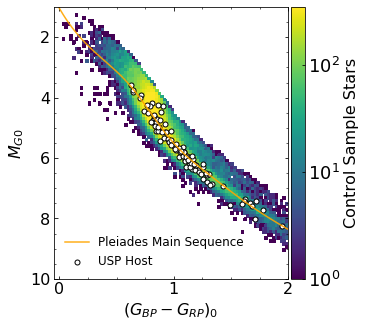

In [39]:
font={'size':16}
plt.rc('font',**font)
bins = (np.linspace(0.0, 2.25, 100),
        np.linspace(0, 10, 100))
H,xe,ye=np.histogram2d(ktcgaia.bp_rp0,ktcgaia.M_G0,bins=bins)
f,ax=plt.subplots(figsize=(5,5))
c=plt.pcolormesh(xe,ye,H.T,cmap='viridis',norm=mpl.colors.LogNorm(vmin=1E0, vmax=350))
plt.scatter(so_only_usps_ms.bp_rp0, so_only_usps_ms.M_G0, s=25, c='white',alpha=1, edgecolor='black', linewidth=1,label='USP Host')
plt.ylim(10,1)
plt.xlim(-0.05,2)
tcks=([-0.1533484 , -0.1533484 , -0.1533484 , -0.1533484 ,  0.63099294,
     0.96258741,  1.30771737,  1.71082406,  2.1444674 ,  2.4671927 ,
     2.5106812 ,  2.57087331,  2.61055761,  2.64182287,  2.65866666,
     2.66738897,  2.69233232,  2.70922952,  2.77087217,  2.82155137,
     2.84336095,  2.8537417 ,  2.89164453,  2.919838  ,  2.95142656,
     2.96471505,  2.98843198,  3.01530652,  3.04317003,  3.05686288,
     3.07316022,  3.10154062,  3.12891012,  3.16318994,  3.21736532,
     3.27362256,  3.3727818 ,  3.68525129,  3.68525129,  3.68525129,
     3.68525129],[-0.1745295 ,  2.3230733 ,  2.54252414,  5.54631992,  6.59988118,
     7.76297267,  8.59023705,  9.17519988,  9.65855025,  9.77533754,
     9.90392849, 10.05051825, 10.13809934, 10.19273253, 10.21350097,
    10.24293815, 10.38722777, 10.6498557 , 10.67855244, 10.68741252,
    10.71899853, 10.92565851, 10.97186376, 11.00763527, 11.08921082,
    11.27865818, 11.34078682, 11.34813415, 11.35886986, 11.42840745,
    11.55213609, 11.6855607 , 11.71061756, 12.12229352, 12.26016258,
    12.22448534, 12.8920296 ,  0.        ,  0.        ,  0.        ,
     0.        ],3)
spl2=UnivariateSpline._from_tck(tcks)
plt.plot(np.linspace(-0.05,2,100), spl2(np.linspace(-0.05,2,100)), label='Pleiades Main Sequence', c='orange', alpha=0.9)
plt.xlabel('$(G_{BP}-G_{RP})_0$')#, fontsize=34, weight='bold')
plt.ylabel('$M_{G0}$')#, fontsize=34, weight='bold')
plt.legend(fontsize=12, frameon=False)
ax.tick_params(direction='out')
ax.yaxis.set_tick_params(direction='in')
ax.xaxis.set_tick_params(direction='in')
cb=plt.colorbar(c,pad=0.01)
cb.set_label(label='Control Sample Stars')#,size=34, weight='bold')
cb.ax.minorticks_off()
cb.ax.tick_params(labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')
plt.savefig('PaperPlots/so_only_usp_gaiams_HR.pdf',bbox_inches='tight', pad_inches=0)
plt.savefig('PaperPlots/so_only_usp_gaiams_HR.png',bbox_inches='tight', pad_inches=0, dpi=300)

In [ ]:
len(pd.concat([so_usps_ms.designation, dr25_usps_ms.designation]).unique())

In [ ]:
dr25uspdev, dr25uspcontroldevs, dr25uspsamps=usp_vs_control_dispersion_hist(dr25_usps_ms, gaiams, mciters=1250)

In [ ]:
souspdev, souspcontroldevs, souspsamps=usp_vs_control_dispersion_hist(so_usps_ms, gaiams, mciters=2000)

In [ ]:
mcfile=open('SOUSPMonteCarloSaved.txt','w+')
mcfile.write('SOUSPdev='+str(souspdev)+'\n')
mcfile.close()
np.savetxt('SOUSPcontroldevs.txt',souspcontroldevs)

In [ ]:
font={'size':28}
plt.rc('font',**font)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,16*.5))

ax.hist(souspcontroldevs, bins = 100)
ax.axvline(souspdev, label = 'USP Hosts',lw=5, color='orange')
#plt.vlines(souspdev, ymin = 0, ymax = maxy, label = 'USP Total Dev', color = 'orange',lw=10)
ax.axvline(x = np.percentile(souspcontroldevs,50), label = 'Median', lw=3,color = 'k')
ax.axvline(x = np.percentile(souspcontroldevs,16,), lw=3,color = 'k', linestyle = '--', label='$1 \sigma$')
ax.axvline(x = np.percentile(souspcontroldevs,84), lw=3,color = 'k', linestyle = '--')
ax.axvline(x = np.percentile(souspcontroldevs,2), lw=3,color = 'k', linestyle = ':', label='$2 \sigma$')
ax.axvline(x = np.percentile(souspcontroldevs,98), lw=3,color = 'k', linestyle = ':')
ax.set_xlabel('Sample Velocity Dispersion [km/s]', size=28)
ax.set_ylabel('N', size=28)
ax.legend(fontsize=28, frameon=False)
#ax.set_xlim(35.75,51)
ax.set_xticks(np.arange(36,64,4))
ax.set_xlim(None, 65)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')

# ax[1].hist(souspcontroldevs2, bins = 100)
# ax[1].axvline(souspdev2, label = 'Jupiter Hosts',lw=5, color='orange')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,50), label = 'Median', lw=3,color = 'k')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,16,), lw=3,color = 'k', linestyle = '--',label='$1 \sigma$')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,84), lw=3,color = 'k', linestyle = '--')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,2), lw=3,color = 'k', linestyle = ':',label='$2 \sigma$')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,98), lw=3,color = 'k', linestyle = ':')
# ax[1].set_xlabel('Sample Velocity Dispersion [km/s]')
# ax[1].set_ylabel('N')
# ax[1].legend(fontsize=12, frameon=False)
# #ax[1].set_xlim(35.75,51)
# ax[1].set_xticks(np.arange(36,52,2))
# ax[1].yaxis.set_major_locator(MultipleLocator(100))
# ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].tick_params(top=True, left=True, right=True, bottom=True, which='both')
# plt.tight_layout()

plt.savefig('PaperPlots/sousp_hist_presentation.png',bbox_inches='tight', dpi=300)
plt.savefig('PaperPlots/sousp_hist_presentation.pdf',bbox_inches='tight')

In [ ]:
font={'size':16}
plt.rc('font',**font)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.1,7.1*.5))

ax.hist(souspcontroldevs, bins = 100)
ax.axvline(souspdev, label = 'USP Hosts',lw=5, color='orange')
#plt.vlines(souspdev, ymin = 0, ymax = maxy, label = 'USP Total Dev', color = 'orange',lw=10)
ax.axvline(x = np.percentile(souspcontroldevs,50), label = 'Median', lw=3,color = 'k')
ax.axvline(x = np.percentile(souspcontroldevs,16,), lw=3,color = 'k', linestyle = '--', label='$1 \sigma$')
ax.axvline(x = np.percentile(souspcontroldevs,84), lw=3,color = 'k', linestyle = '--')
ax.axvline(x = np.percentile(souspcontroldevs,2), lw=3,color = 'k', linestyle = ':', label='$2 \sigma$')
ax.axvline(x = np.percentile(souspcontroldevs,98), lw=3,color = 'k', linestyle = ':')
ax.set_xlabel('Sample Velocity Dispersion [km/s]')
ax.set_ylabel('N')
ax.legend(fontsize=12, frameon=False)
#ax.set_xlim(35.75,51)
ax.set_xticks(np.arange(36,52,2))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')

# ax[1].hist(souspcontroldevs2, bins = 100)
# ax[1].axvline(souspdev2, label = 'Jupiter Hosts',lw=5, color='orange')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,50), label = 'Median', lw=3,color = 'k')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,16,), lw=3,color = 'k', linestyle = '--',label='$1 \sigma$')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,84), lw=3,color = 'k', linestyle = '--')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,2), lw=3,color = 'k', linestyle = ':',label='$2 \sigma$')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,98), lw=3,color = 'k', linestyle = ':')
# ax[1].set_xlabel('Sample Velocity Dispersion [km/s]')
# ax[1].set_ylabel('N')
# ax[1].legend(fontsize=12, frameon=False)
# #ax[1].set_xlim(35.75,51)
# ax[1].set_xticks(np.arange(36,52,2))
# ax[1].yaxis.set_major_locator(MultipleLocator(100))
# ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].tick_params(top=True, left=True, right=True, bottom=True, which='both')
# plt.tight_layout()

plt.savefig('PaperPlots/sousp_combined_hist.png',bbox_inches='tight', dpi=300)
plt.savefig('PaperPlots/sousp_combined_hist.pdf',bbox_inches='tight')

In [ ]:
print(len(uspcontroldevs[uspcontroldevs<uspdev])/len(uspcontroldevs)*100, ' %')

/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:591: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


i =  0 2019-12-30 15:35:35.643849
i =  600 2019-12-30 15:39:24.181416
i =  1200 2019-12-30 15:43:12.346897
i =  1800 2019-12-30 15:47:00.695772
i =  2400 2019-12-30 15:50:50.269332
i =  3000 2019-12-30 15:55:52.714307
i =  3600 2019-12-30 16:00:20.327755
i =  4200 2019-12-30 16:04:31.813495
i =  4800 2019-12-30 16:08:38.783466
i =  5400 2019-12-30 16:12:52.850105


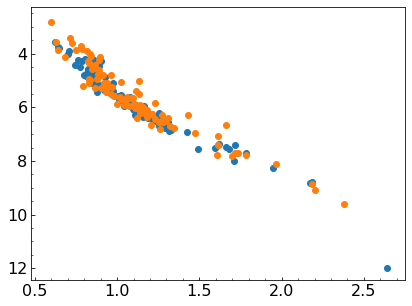

In [40]:
so_only_uspdev, so_only_uspcontroldevs, so_only_uspsamps=usp_vs_control_dispersion_hist(so_only_usps_ms, ktcgaia, mciters=6000)

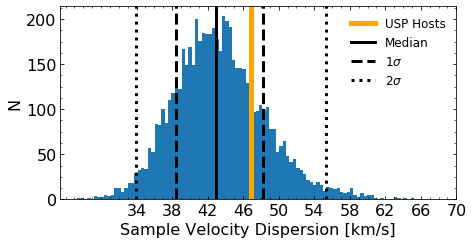

In [41]:
font={'size':16}
plt.rc('font',**font)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.1,7.1*.5))

ax.hist(so_only_uspcontroldevs, bins = 100)
ax.axvline(so_only_uspdev, label = 'USP Hosts',lw=5, color='orange')
#plt.vlines(so_only_uspdev, ymin = 0, ymax = maxy, label = 'USP Total Dev', color = 'orange',lw=10)
ax.axvline(x = np.percentile(so_only_uspcontroldevs,50), label = 'Median', lw=3,color = 'k')
ax.axvline(x = np.percentile(so_only_uspcontroldevs,16,), lw=3,color = 'k', linestyle = '--', label='$1 \sigma$')
ax.axvline(x = np.percentile(so_only_uspcontroldevs,84), lw=3,color = 'k', linestyle = '--')
ax.axvline(x = np.percentile(so_only_uspcontroldevs,2), lw=3,color = 'k', linestyle = ':', label='$2 \sigma$')
ax.axvline(x = np.percentile(so_only_uspcontroldevs,98), lw=3,color = 'k', linestyle = ':')
ax.set_xlabel('Sample Velocity Dispersion [km/s]')
ax.set_ylabel('N')
ax.legend(fontsize=12, frameon=False)
#ax.set_xlim(35.75,51)
ax.set_xticks(np.arange(34,74,4))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')

# ax[1].hist(so_only_uspcontroldevs2, bins = 100)
# ax[1].axvline(so_only_uspdev2, label = 'Jupiter Hosts',lw=5, color='orange')
# ax[1].axvline(x = np.percentile(so_only_uspcontroldevs2,50), label = 'Median', lw=3,color = 'k')
# ax[1].axvline(x = np.percentile(so_only_uspcontroldevs2,16,), lw=3,color = 'k', linestyle = '--',label='$1 \sigma$')
# ax[1].axvline(x = np.percentile(so_only_uspcontroldevs2,84), lw=3,color = 'k', linestyle = '--')
# ax[1].axvline(x = np.percentile(so_only_uspcontroldevs2,2), lw=3,color = 'k', linestyle = ':',label='$2 \sigma$')
# ax[1].axvline(x = np.percentile(so_only_uspcontroldevs2,98), lw=3,color = 'k', linestyle = ':')
# ax[1].set_xlabel('Sample Velocity Dispersion [km/s]')
# ax[1].set_ylabel('N')
# ax[1].legend(fontsize=12, frameon=False)
# #ax[1].set_xlim(35.75,51)
# ax[1].set_xticks(np.arange(36,52,2))
# ax[1].yaxis.set_major_locator(MultipleLocator(100))
# ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].tick_params(top=True, left=True, right=True, bottom=True, which='both')
# plt.tight_layout()

plt.savefig('PaperPlots/so_only_usp_combined_hist.png',bbox_inches='tight', dpi=300)
plt.savefig('PaperPlots/so_only_usp_combined_hist.pdf',bbox_inches='tight')

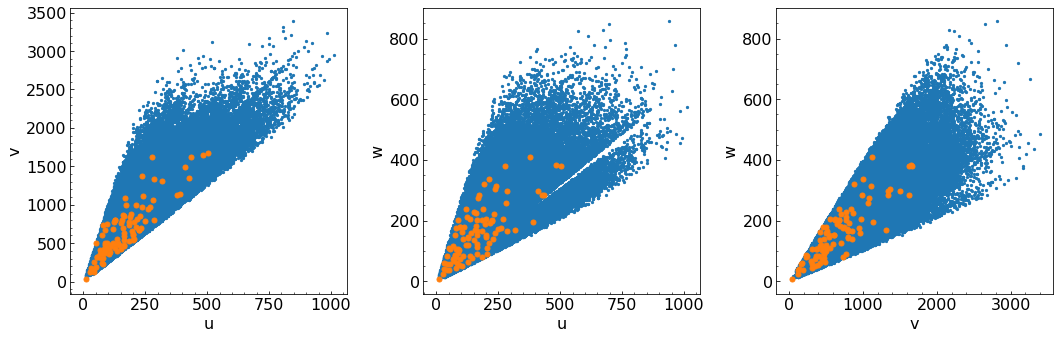

In [45]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(131)
ax.scatter(ktcgaia.gal_u, ktcgaia.gal_v, s=5)
ax.scatter(so_only_usps_ms.gal_u, so_only_usps_ms.gal_v, s=25)
ax.set_xlabel('u')
ax.set_ylabel('v')
ax=fig.add_subplot(132)
ax.scatter(ktcgaia.gal_u, ktcgaia.gal_w, s=5)
ax.scatter(so_only_usps_ms.gal_u, so_only_usps_ms.gal_w, s=25)
ax.set_xlabel('u')
ax.set_ylabel('w')
ax=fig.add_subplot(133)
ax.scatter(ktcgaia.gal_v, ktcgaia.gal_w, s=5)
ax.scatter(so_only_usps_ms.gal_v, so_only_usps_ms.gal_w, s=25)
ax.set_xlabel('v')
ax.set_ylabel('w')
plt.tight_layout()

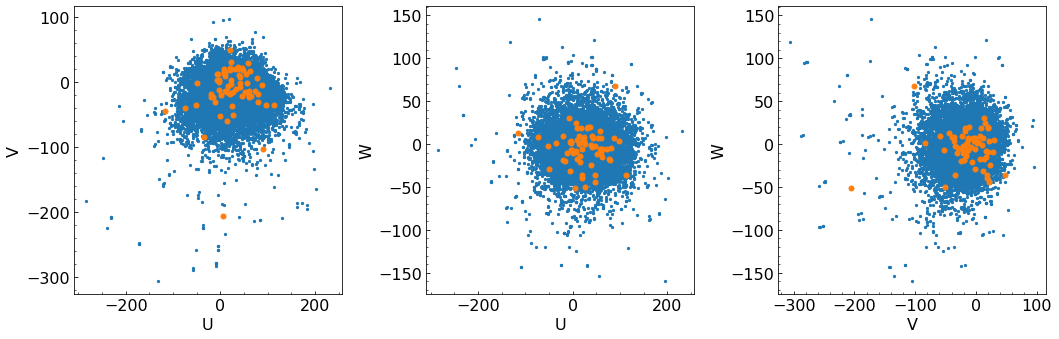

In [47]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(131)
ax.scatter(ktcgaia.gal_U, ktcgaia.gal_V, s=5)
ax.scatter(so_only_usps_ms.gal_U, so_only_usps_ms.gal_V, s=25)
ax.set_xlabel('U')
ax.set_ylabel('V')
ax=fig.add_subplot(132)
ax.scatter(ktcgaia.gal_U, ktcgaia.gal_W, s=5)
ax.scatter(so_only_usps_ms.gal_U, so_only_usps_ms.gal_W, s=25)
ax.set_xlabel('U')
ax.set_ylabel('W')
ax=fig.add_subplot(133)
ax.scatter(ktcgaia.gal_V, ktcgaia.gal_W, s=5)
ax.scatter(so_only_usps_ms.gal_V, so_only_usps_ms.gal_W, s=25)
ax.set_xlabel('V')
ax.set_ylabel('W')
plt.tight_layout()

Text(0, 0.5, '$(U^2+W^2)^{0.5}$')

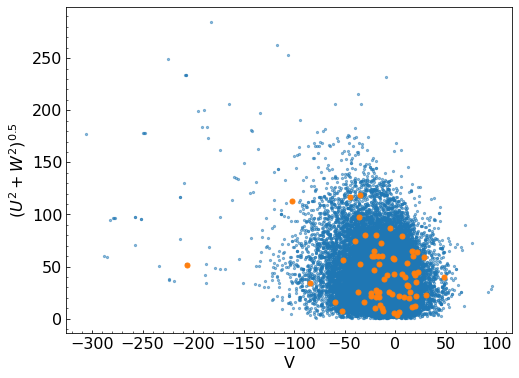

In [50]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.scatter(ktcgaia.gal_V, np.sqrt(ktcgaia.gal_U**2+ktcgaia.gal_W**2), s=5, alpha=0.5)
ax.scatter(so_only_usps_ms.gal_V, np.sqrt(so_only_usps_ms.gal_U**2+so_only_usps_ms.gal_W**2), s=25)
ax.set_xlabel('V')
ax.set_ylabel('$(U^2+W^2)^{0.5}$')

(array([0.0015652 , 0.00469561, 0.00417387, 0.00417387, 0.00495647,
        0.0015652 , 0.00130434, 0.00130434, 0.00026087, 0.00104347]),
 array([  8.71245218,  48.64340033,  88.57434848, 128.50529664,
        168.43624479, 208.36719295, 248.2981411 , 288.22908926,
        328.16003741, 368.09098557, 408.02193372]),
 <a list of 10 Patch objects>)

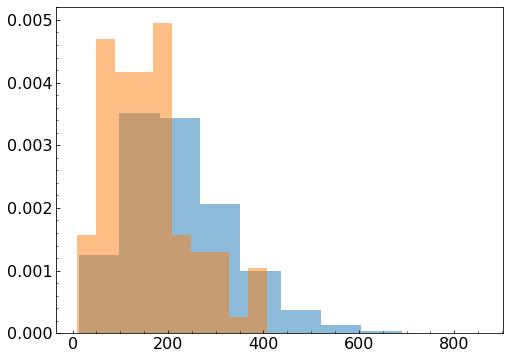

In [53]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.hist(ktcgaia.gal_w, density=True, alpha=0.5)
ax.hist(so_only_usps_ms.gal_w, density=True, alpha=0.5)